<a href="https://colab.research.google.com/github/UnitForDataScience/Projects-Fall-2024/blob/main/Retinopathy_Debrecen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset Variable Descriptions

The table below outlines the variables included in the dataset, along with their roles, types, descriptions, and information on missing values.

| Variable Name               | Role    | Type       | Description                                                                                                                                                                                | Missing Values |
|-----------------------------|---------|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| `quality`                   | Feature | Binary     | Image quality represented as binary values: 1 = good quality, 0 = bad quality.                                                                                                             | No             |
| `pre_screening`             | Feature | Binary     | Pre-screening information represented as binary values: 1 = severe abnormality in the retina, 0 = no abnormality.                                                                           | No             |
| `ma1`                       | Feature | Integer    | Number of microaneurysms (MAs) detected at a confidence interval of 0.5. MAs are tiny bulges in retinal blood vessels that can leak blood, an early sign of diabetic retinopathy.            | No             |
| `ma2`                       | Feature | Integer    | Number of microaneurysms (MAs) detected at a confidence interval of 0.6.                                                                                                                    | No             |
| `ma3`                       | Feature | Integer    | Number of microaneurysms (MAs) detected at a confidence interval of 0.7.                                                                                                                    | No             |
| `ma4`                       | Feature | Integer    | Number of microaneurysms (MAs) detected at a confidence interval of 0.8.                                                                                                                    | No             |
| `ma5`                       | Feature | Integer    | Number of microaneurysms (MAs) detected at a confidence interval of 0.9.                                                                                                                    | No             |
| `ma6`                       | Feature | Integer    | Number of microaneurysms (MAs) detected at a confidence interval of 1.0.                                                                                                                    | No             |
| `exudate1`                  | Feature | Continuous | Exudate detection results normalized by dividing the number of lesions by the diameter of the Region of Interest (ROI) to compensate for different image sizes. Exudates are lipid or protein deposits in the retina, caused by leaking blood vessels. | No             |
| `exudate2`                  | Feature | Continuous | Same as `exudate1` but at a different confidence level.                                                                                                                                     | No             |
| `exudate3`                  | Feature | Continuous | Same as `exudate1` but at a different confidence level.                                                                                                                                     | No             |
| `exudate4`                  | Feature | Continuous | Same as `exudate1` but at a different confidence level.                                                                                                                                     | No             |
| `exudate5`                  | Feature | Continuous | Same as `exudate1` but at a different confidence level.                                                                                                                                     | No             |
| `exudate6`                  | Feature | Continuous | Same as `exudate1` but at a different confidence level.                                                                                                                                     | No             |
| `exudate7`                  | Feature | Continuous | Same as `exudate1` but at a different confidence level.                                                                                                                                     | No             |
| `exudate8`                  | Feature | Continuous | Same as `exudate1` but at a different confidence level.                                                                                                                                     | No             |
| `macula_opticdisc_distance` | Feature | Continuous | The Euclidean distance of the center of the macula and the center of the optic disc, providing important information regarding the patient's condition. This feature is normalized with the diameter of the ROI. | No             |
| `opticdisc_diameter`        | Feature | Continuous | The diameter of the optic disc.                                                                                                                                                             | No             |
| `am_fm_classification`      | Feature | Binary     | The binary result of the AM/FM-based classification.                                                                                                                                        | No             |
| `label`                     | Target  | Binary     | Class labels represented as binary values: 1 = symptoms of diabetic retinopathy (DR), 0 = no symptoms.                                                                                      | No             |

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import pointbiserialr
import plotly.express as px

from sklearn.model_selection import GridSearchCV

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/UnitForDataScience/Projects-Fall-2024/refs/heads/main/RetinoVision/Retinopathy_Debrecen.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1151 non-null   int64  
 1   quality                    1151 non-null   int64  
 2   pre_screening              1151 non-null   int64  
 3   ma1                        1151 non-null   int64  
 4   ma2                        1151 non-null   int64  
 5   ma3                        1151 non-null   int64  
 6   ma4                        1151 non-null   int64  
 7   ma5                        1151 non-null   int64  
 8   ma6                        1151 non-null   int64  
 9   exudate1                   1151 non-null   float64
 10  exudate2                   1151 non-null   float64
 11  exudate3                   1151 non-null   float64
 12  exudate5                   1151 non-null   float64
 13  exudate6                   1151 non-null   float

In [18]:
### good practice to group features based on types

# list of binary features
binary_features = ['quality', 'pre_screening', 'am_fm_classification']

# list of continuous features
continuous_features = ['macula_opticdisc_distance', 'opticdisc_diameter',
                       'exudate1', 'exudate2', 'exudate3', 'exudate5',
                       'exudate6', 'exudate7', 'exudate8']

# list of integer features
integer_features = ['ma1', 'ma2', 'ma3', 'ma4', 'ma5', 'ma6']

con_int = ['macula_opticdisc_distance', 'opticdisc_diameter',
                       'exudate1', 'exudate2', 'exudate3', 'exudate5',
                       'exudate6', 'exudate7', 'exudate8', 'ma1', 'ma2', 'ma3', 'ma4', 'ma5', 'ma6']

In [19]:
df.isnull().sum()

,0
Unnamed: 0,0
quality,0
pre_screening,0
ma1,0
ma2,0
ma3,0
ma4,0
ma5,0
ma6,0
exudate1,0


In [20]:
df.describe()

,Unnamed: 0,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification,class
count,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000
mean,575.000000,0.996525,0.918332,38.428323,36.909644,35.140747,32.297133,28.747176,21.151173,64.096674,23.088012,8.704610,0.560738,0.212290,0.085674,0.037225,0.523212,0.108431,0.336229,0.530843
std,332.409386,0.058874,0.273977,25.620913,24.105612,22.805400,21.114767,19.509227,15.101560,58.485289,21.602696,11.567589,2.484111,1.057126,0.398717,0.178959,0.028055,0.017945,0.472624,0.499265
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.349274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367762,0.057906,0.000000,0.000000
25%,287.500000,1.000000,1.000000,16.000000,16.000000,15.000000,14.000000,11.000000,8.000000,22.271597,7.939315,1.249050,0.000000,0.000000,0.000000,0.000000,0.502855,0.095799,0.000000,0.000000
50%,575.000000,1.000000,1.000000,35.000000,35.000000,32.000000,29.000000,25.000000,18.000000,44.249119,17.038020,4.423472,0.022248,0.001554,0.000000,0.000000,0.523308,0.106623,0.000000,1.000000
75%,862.500000,1.000000,1.000000,55.000000,53.000000,51.000000,48.000000,43.000000,32.000000,87.804112,31.305692,11.766880,0.191953,0.038450,0.004832,0.003851,0.543670,0.119591,1.000000,1.000000
max,1150.000000,1.000000,1.000000,151.000000,132.000000,120.000000,105.000000,97.000000,89.000000,403.939108,167.131427,106.070092,51.423208,20.098605,5.937799,3.086753,0.592217,0.219199,1.000000,1.000000


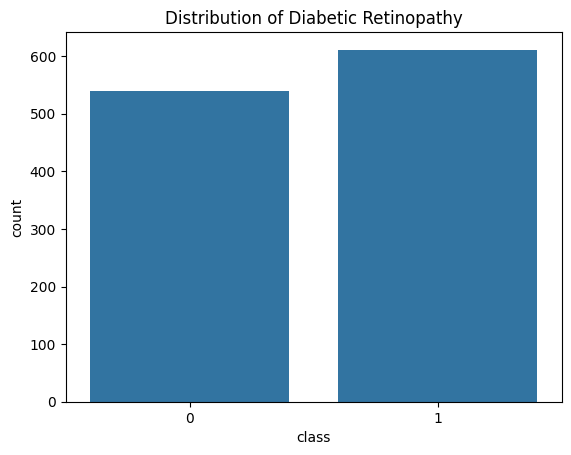

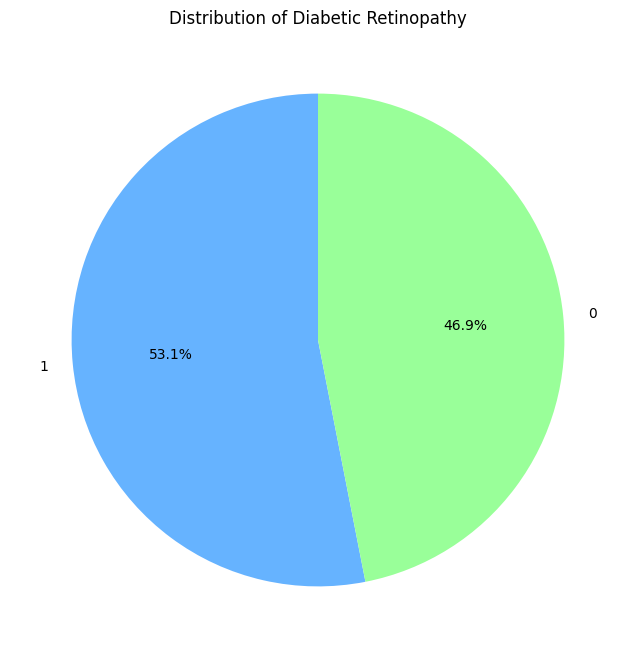

In [21]:
### plot distribution of target variable


# count plot of target variable
sns.countplot(x='class', data=df)
plt.title('Distribution of Diabetic Retinopathy')
plt.show()



# pie chart of target variable
label_counts = df['class'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Distribution of Diabetic Retinopathy')
plt.show()

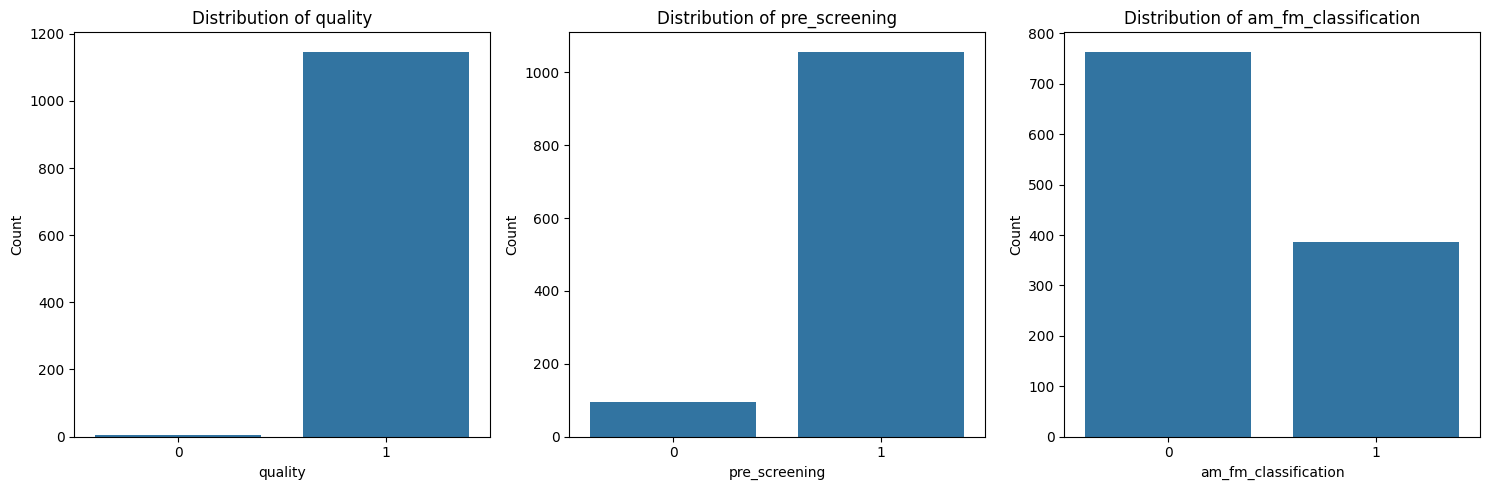

In [22]:
### histogram of binary variables

plt.figure(figsize=(15, 5))
for i, col in enumerate(binary_features, 1):
    plt.subplot(1, len(binary_features), i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

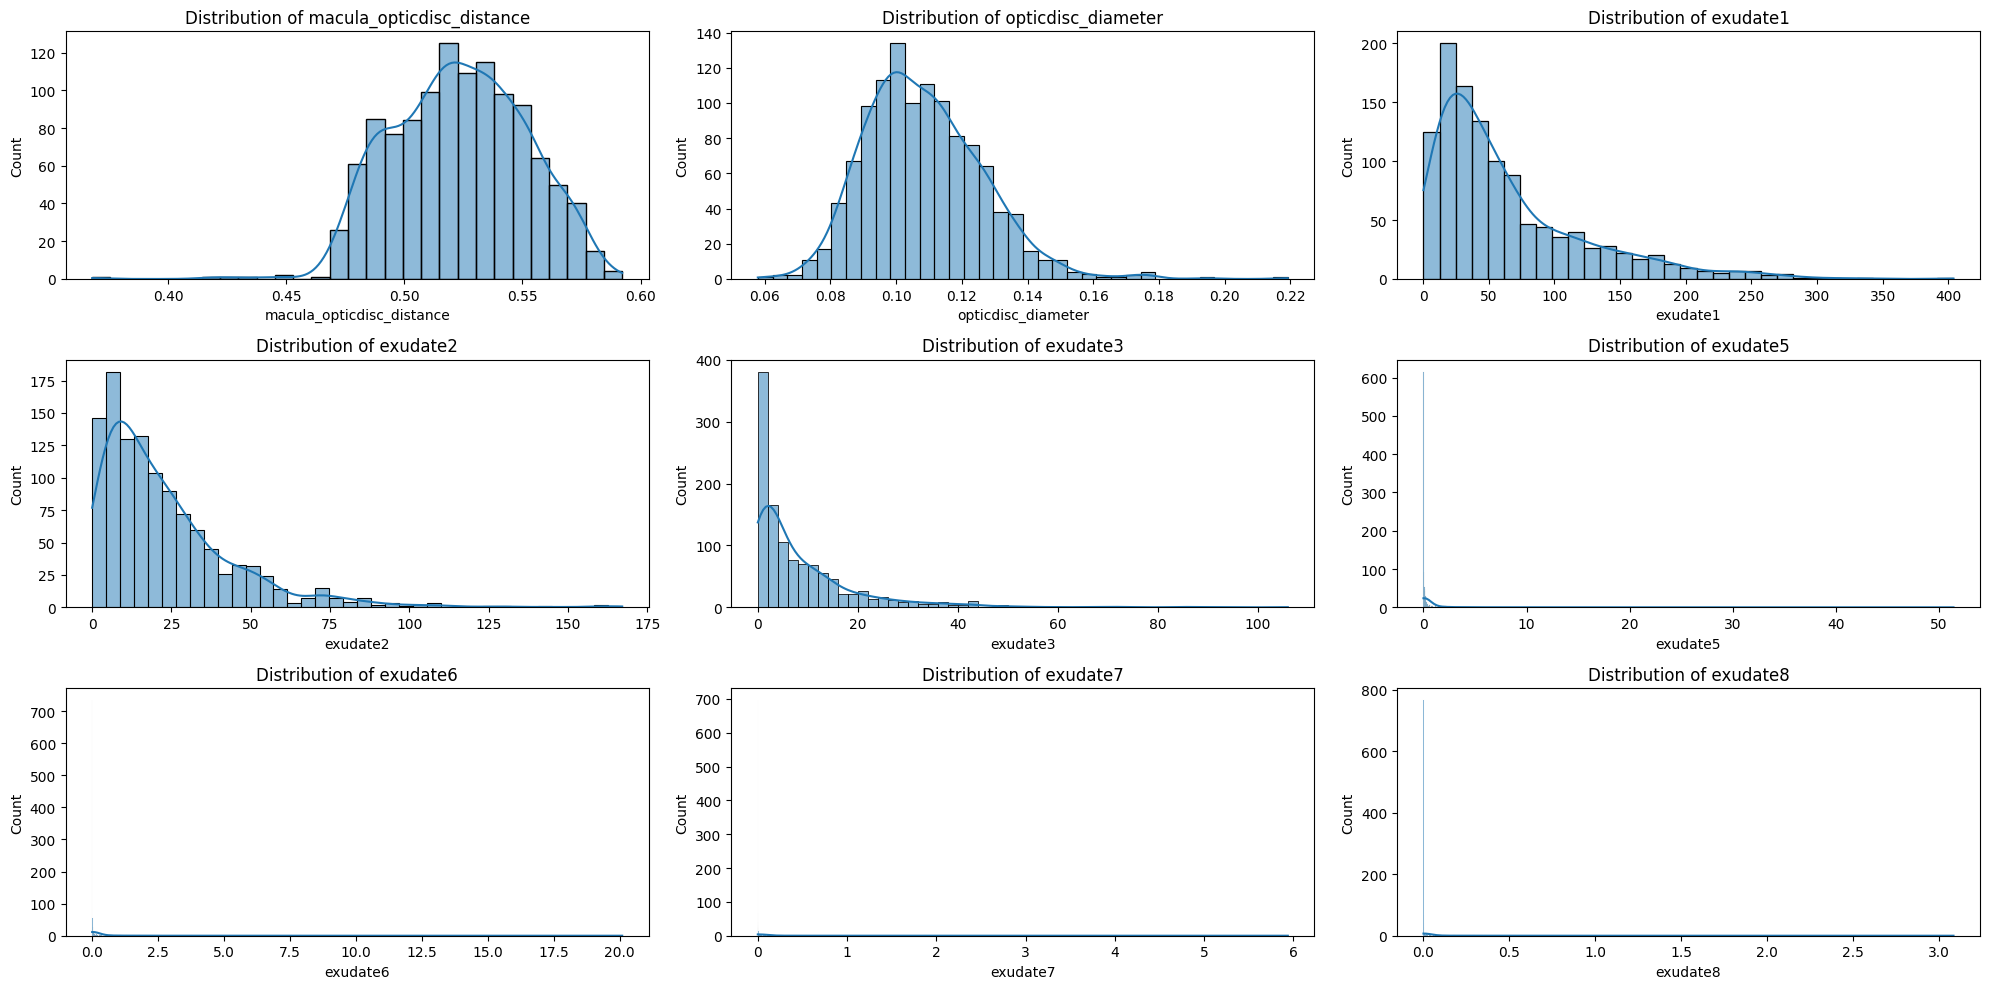

In [23]:
### histogram of continous variables


plt.figure(figsize=(20, 10))
for i, col in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

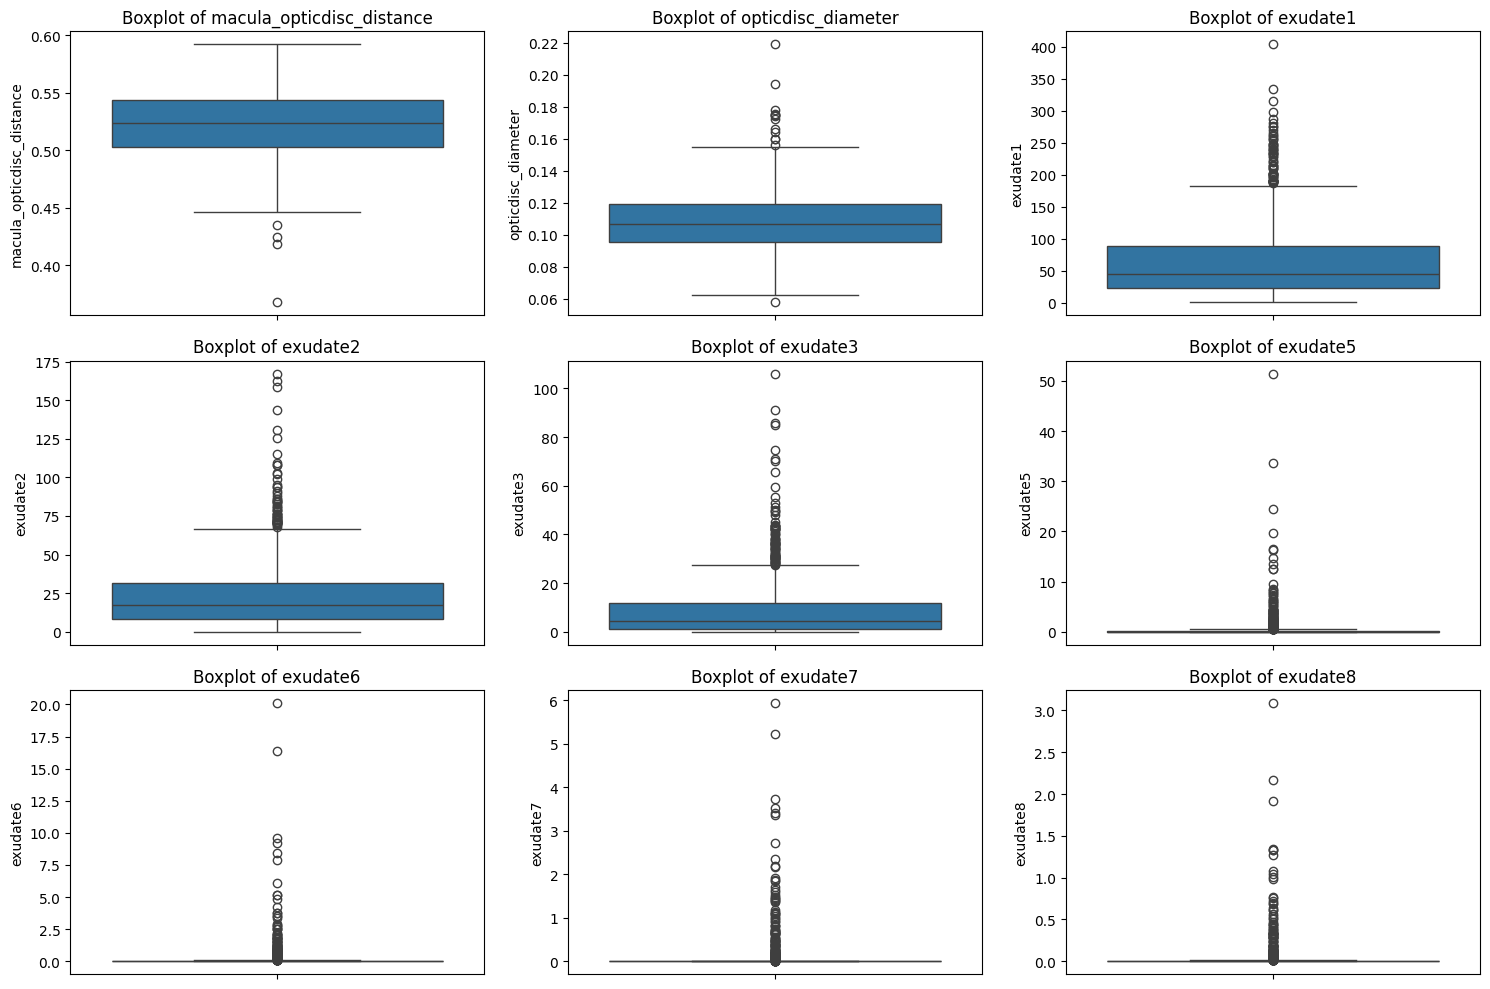

In [24]:
### box plot of continous variables

plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=col, data=df)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

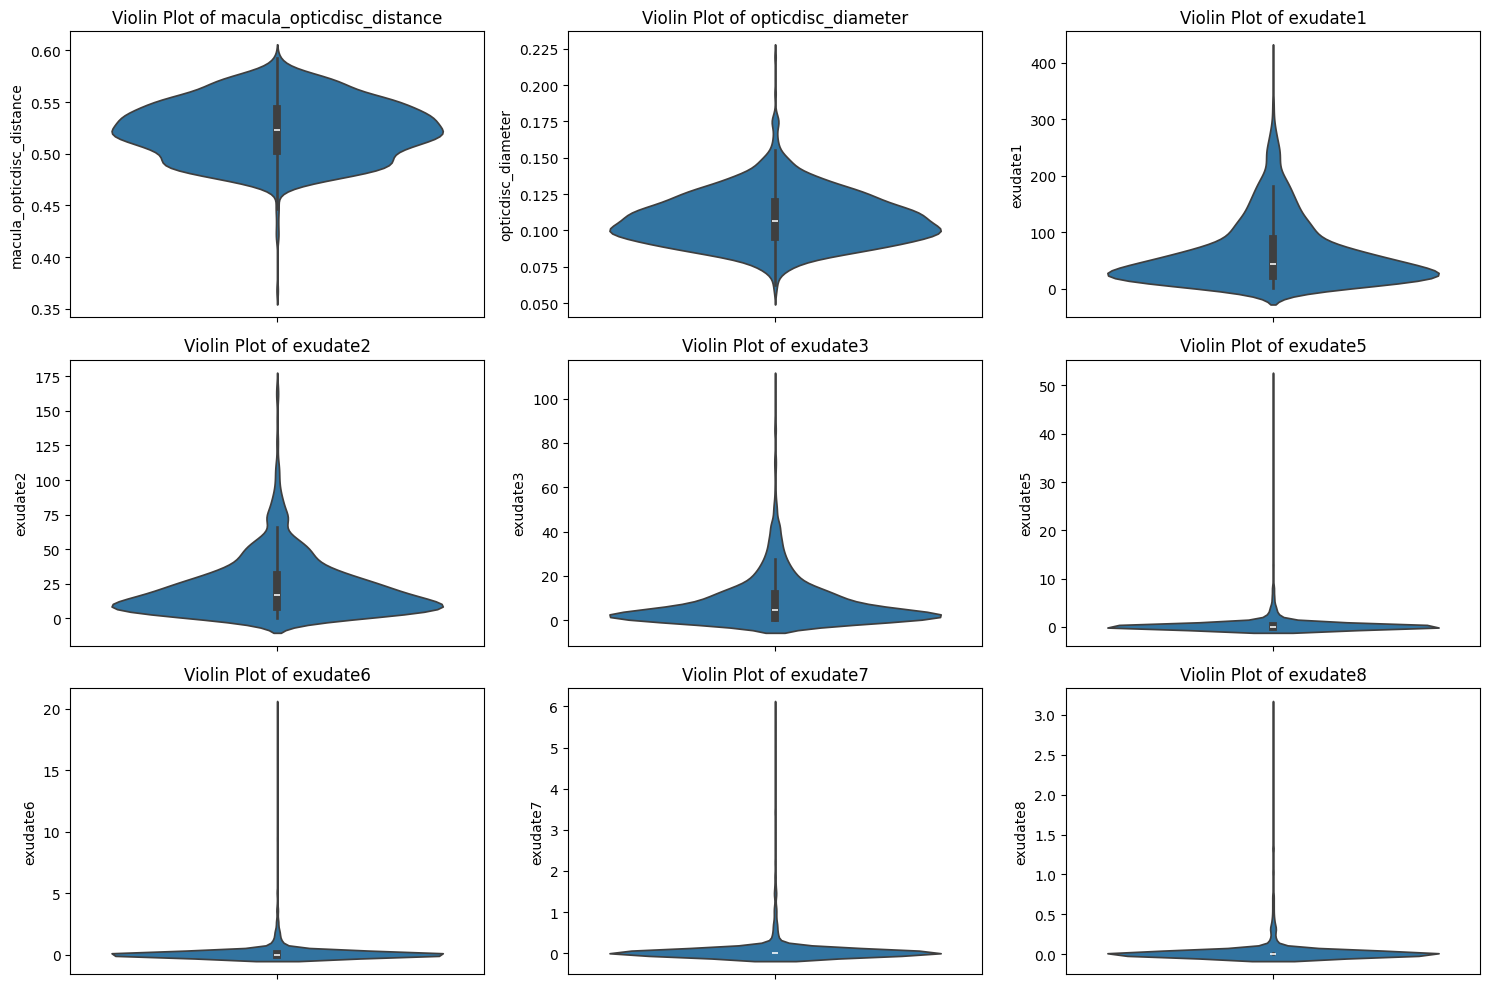

In [25]:
### violin plot of continous variables

plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(y=col, data=df)
    plt.title(f'Violin Plot of {col}')
plt.tight_layout()
plt.show()

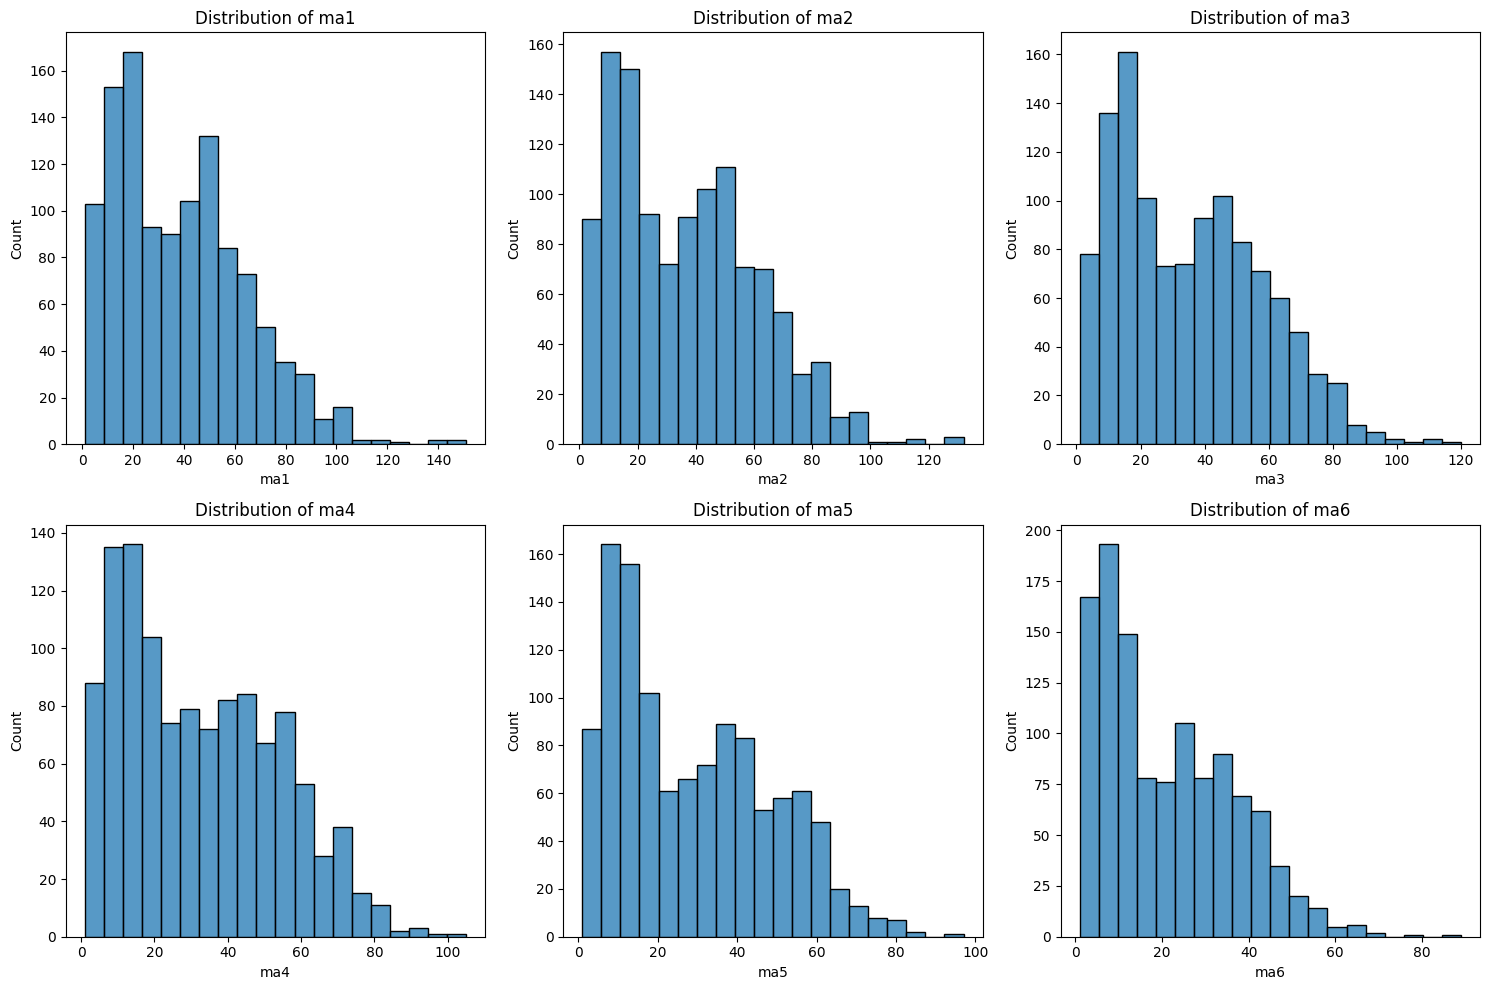

In [26]:
### histogram of integers

plt.figure(figsize=(15, 10))
for i, col in enumerate(integer_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=False, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

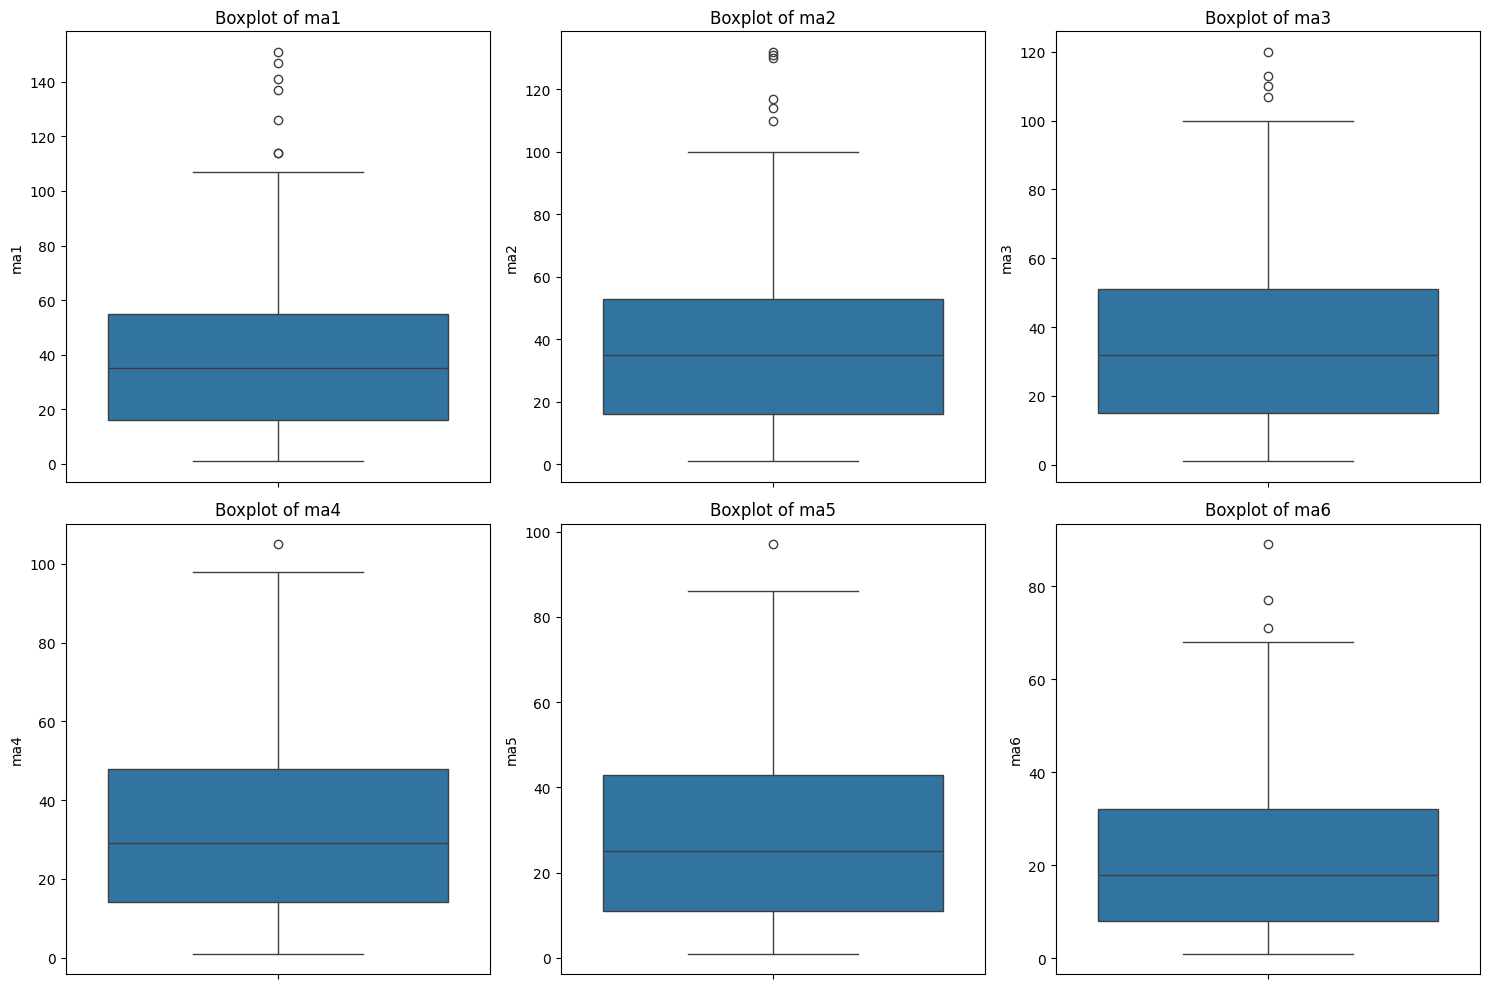

In [27]:
### boxplot of integers

plt.figure(figsize=(15, 10))
for i, col in enumerate(integer_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=col, data=df)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

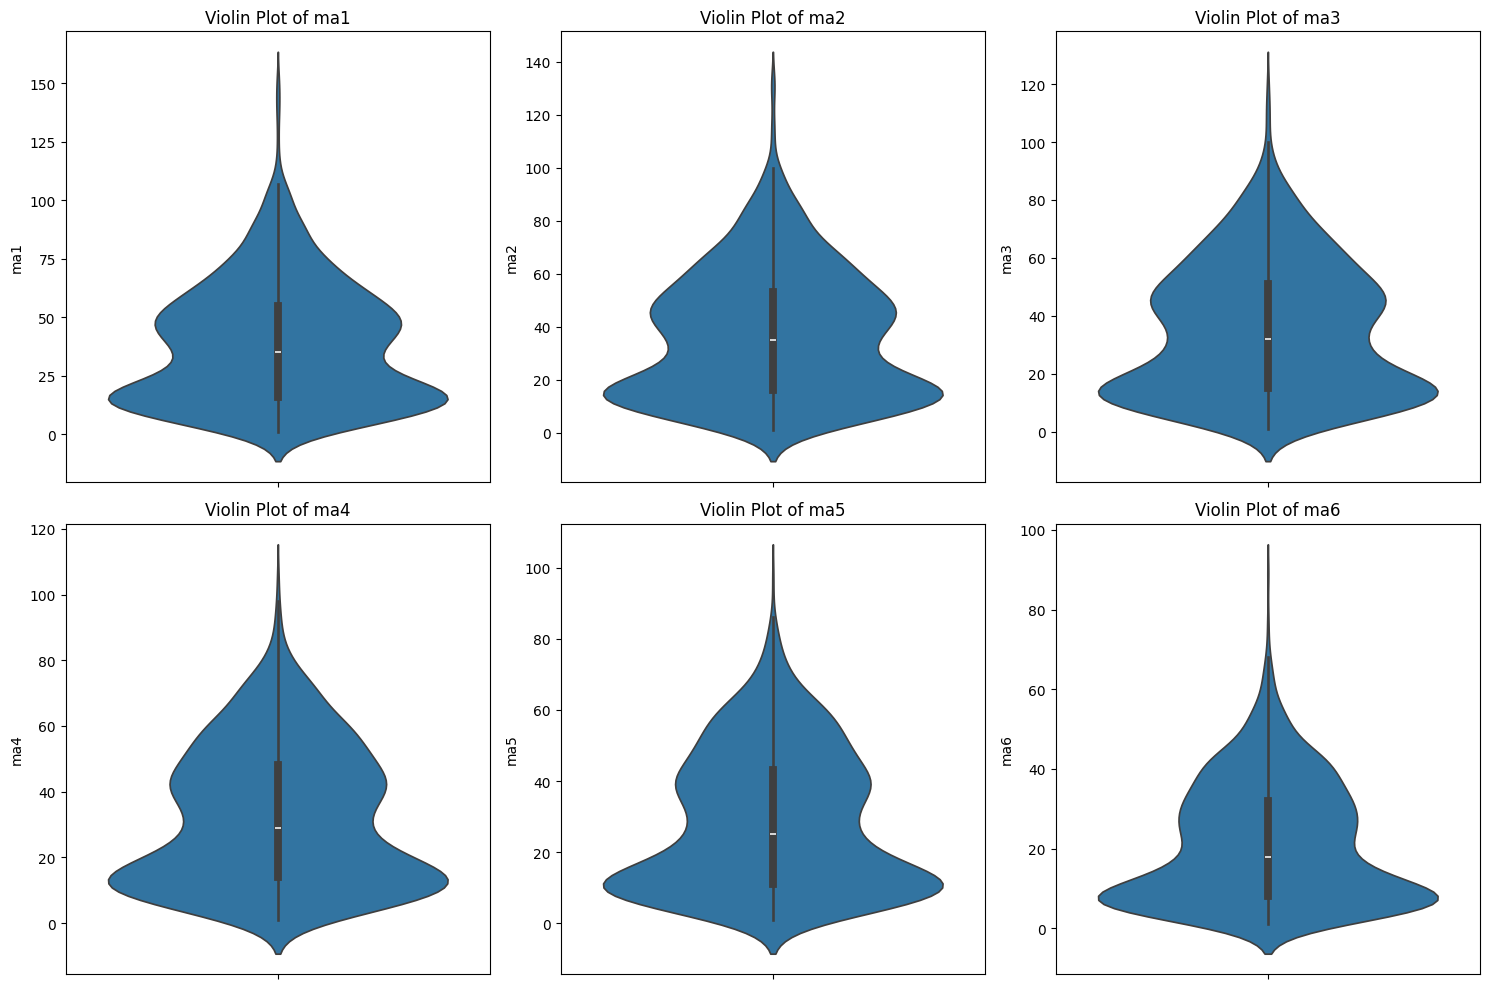

In [28]:
### violin of integers

plt.figure(figsize=(15, 10))
for i, col in enumerate(integer_features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(y=col, data=df)
    plt.title(f'Violin Plot of {col}')
plt.tight_layout()
plt.show()

## <center> Explanatory Data Analysis

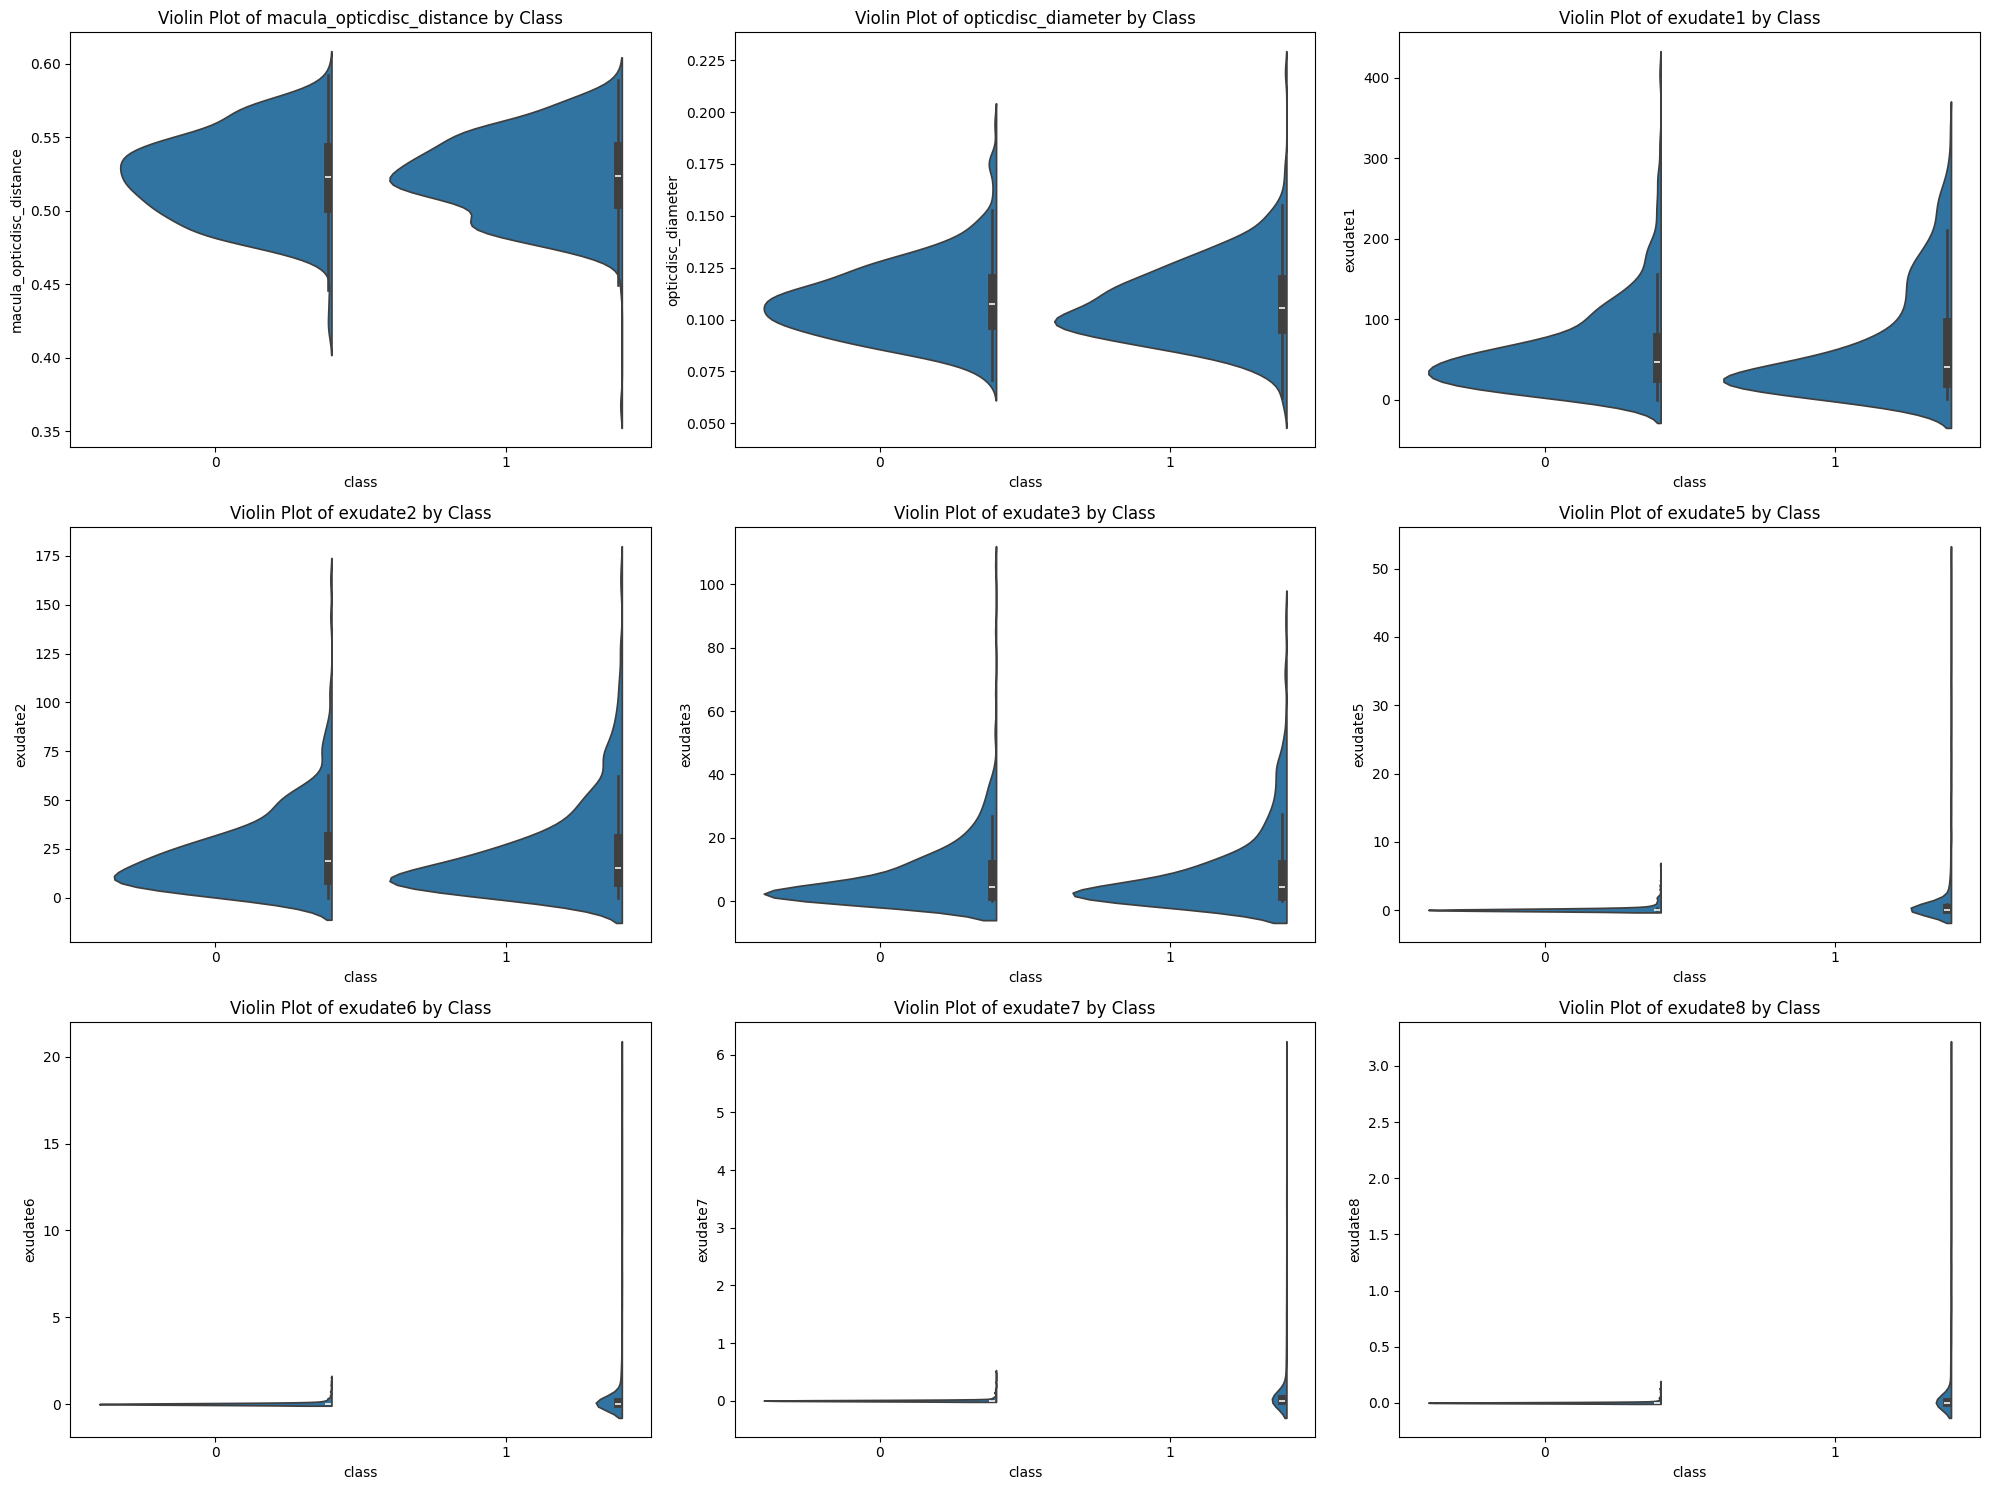

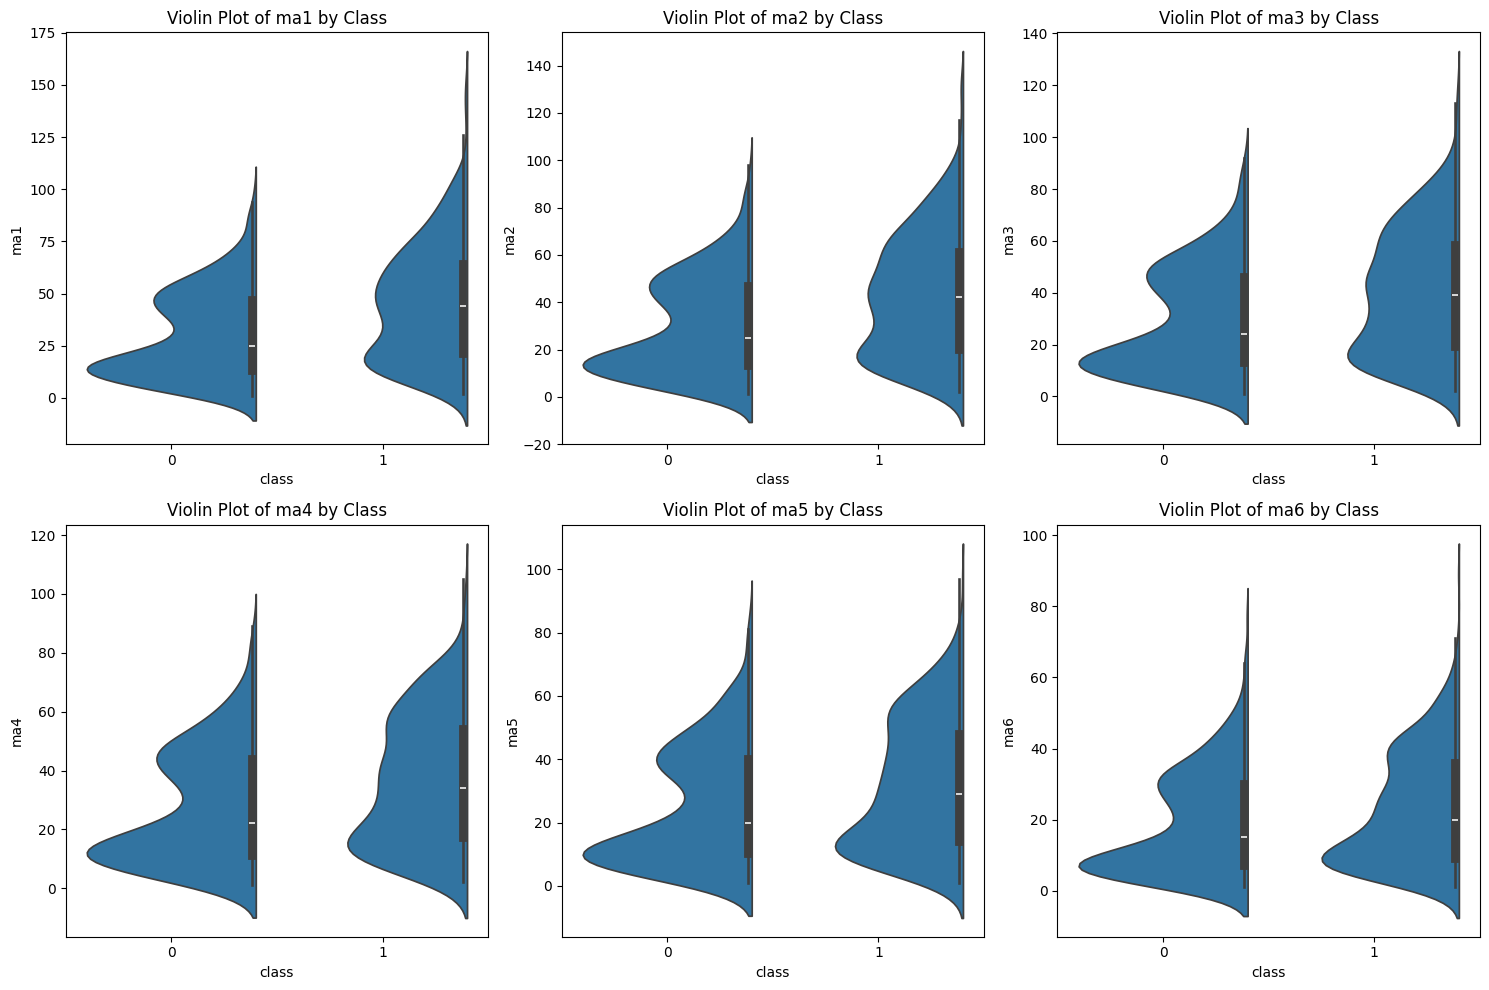

In [29]:
### Violin plots - good to show shapes

# continous variables
plt.figure(figsize=(20, 15))
for i, col in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x='class', y=col, data=df, split=True)
    plt.title(f'Violin Plot of {col} by Class')
plt.tight_layout()
plt.show()




# integer variables
integer_features = ['ma1', 'ma2', 'ma3', 'ma4', 'ma5', 'ma6']

plt.figure(figsize=(15, 10))
for i, col in enumerate(integer_features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='class', y=col, data=df, split=True)
    plt.title(f'Violin Plot of {col} by Class')
plt.tight_layout()
plt.show()

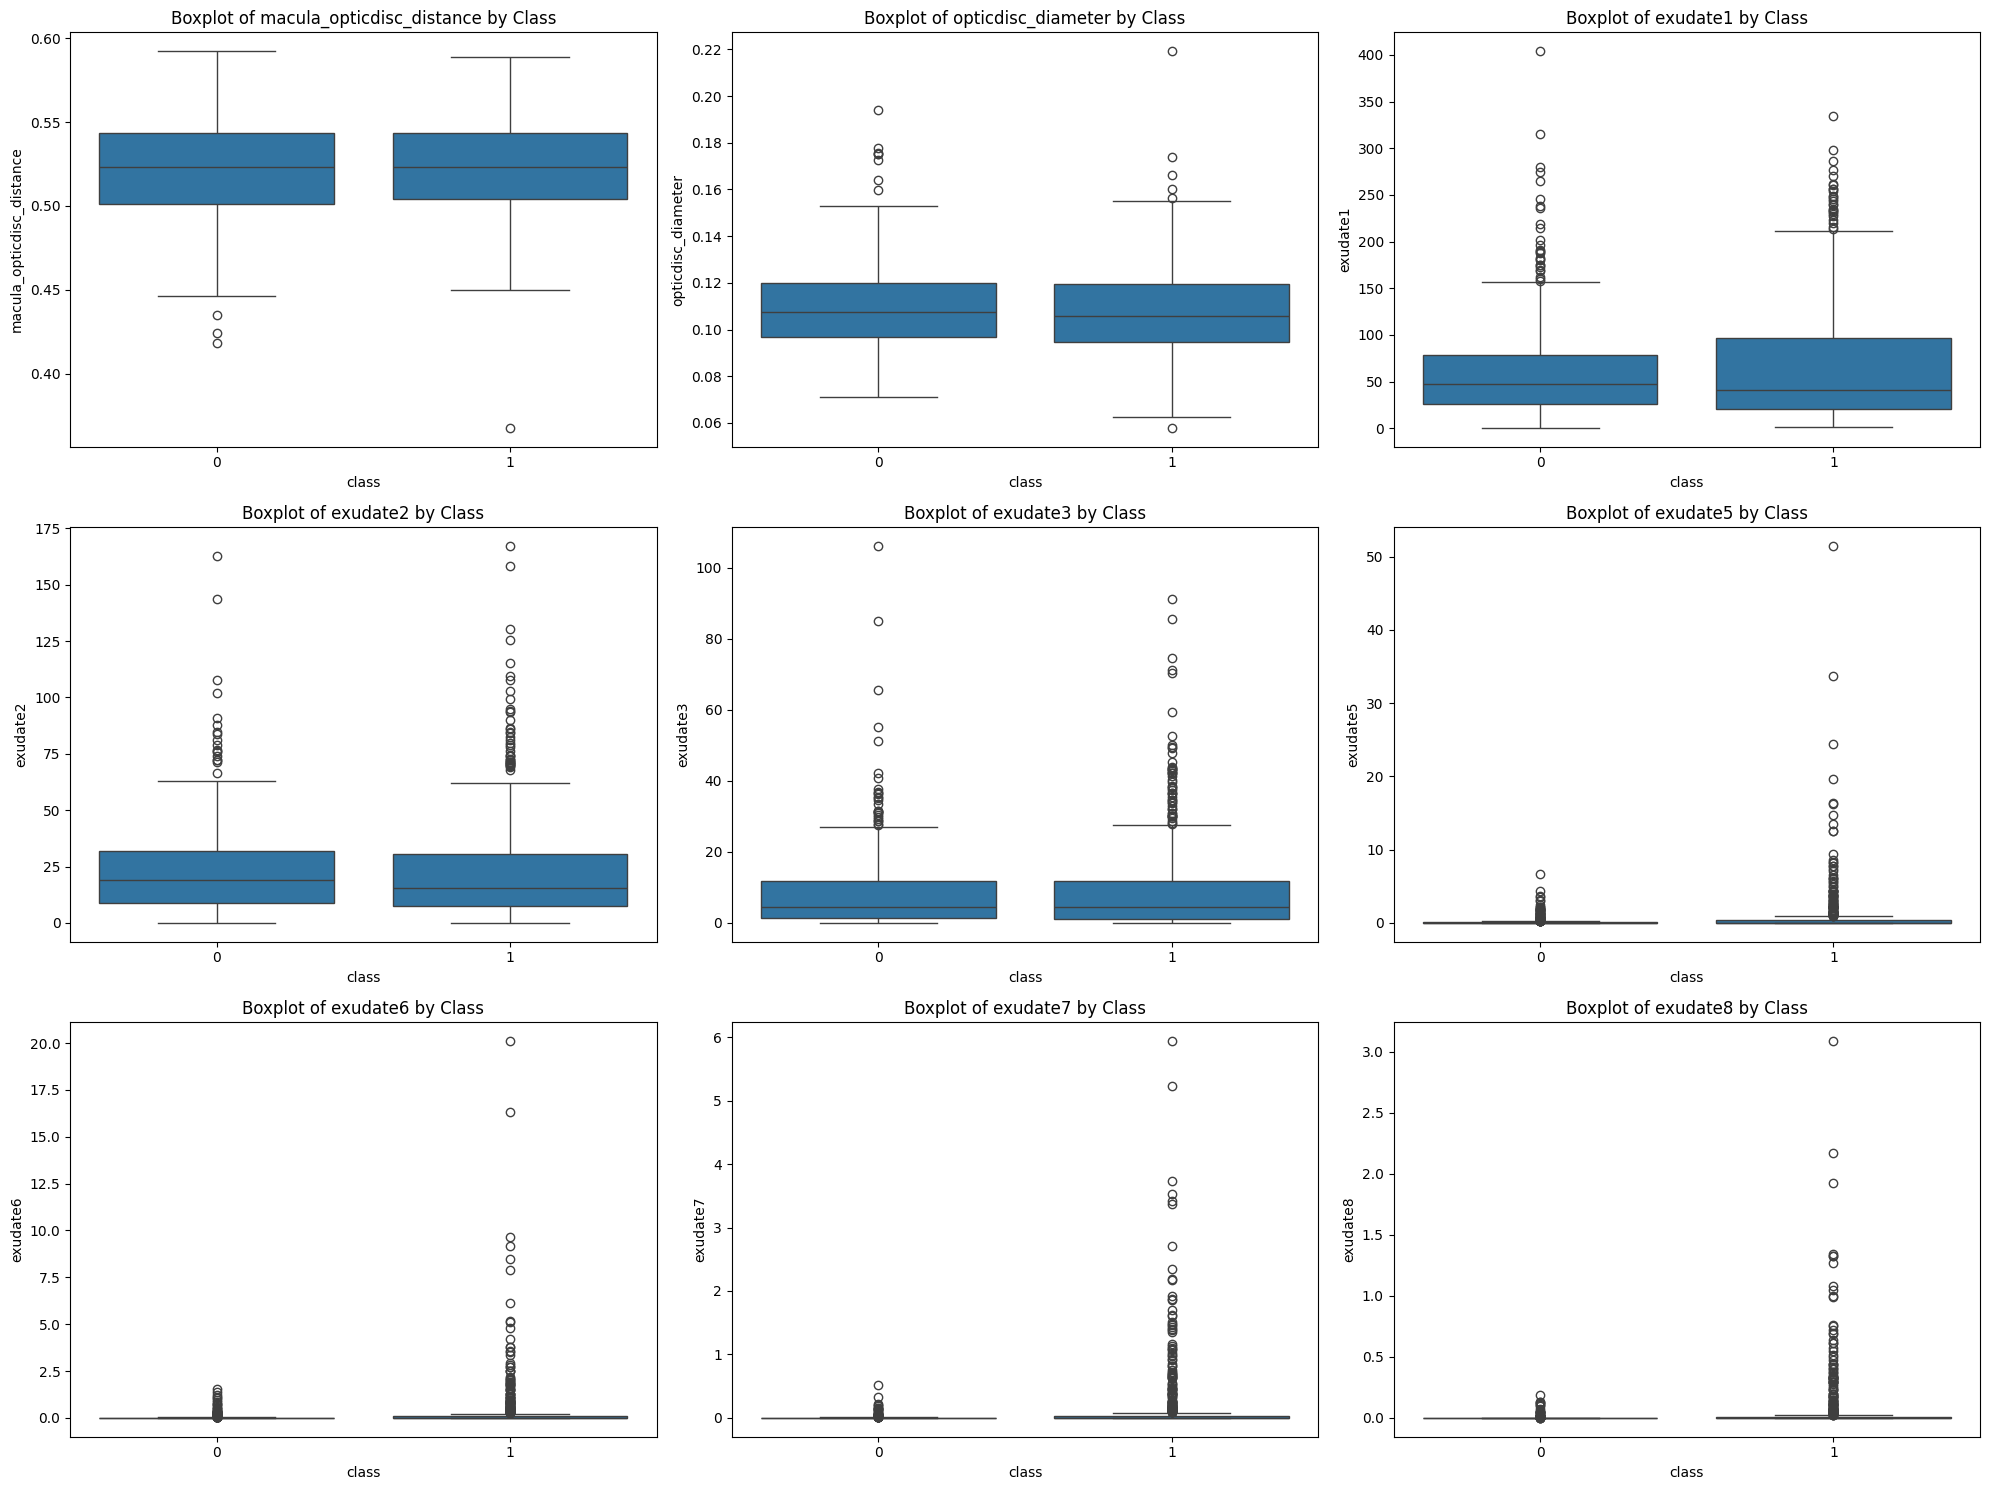

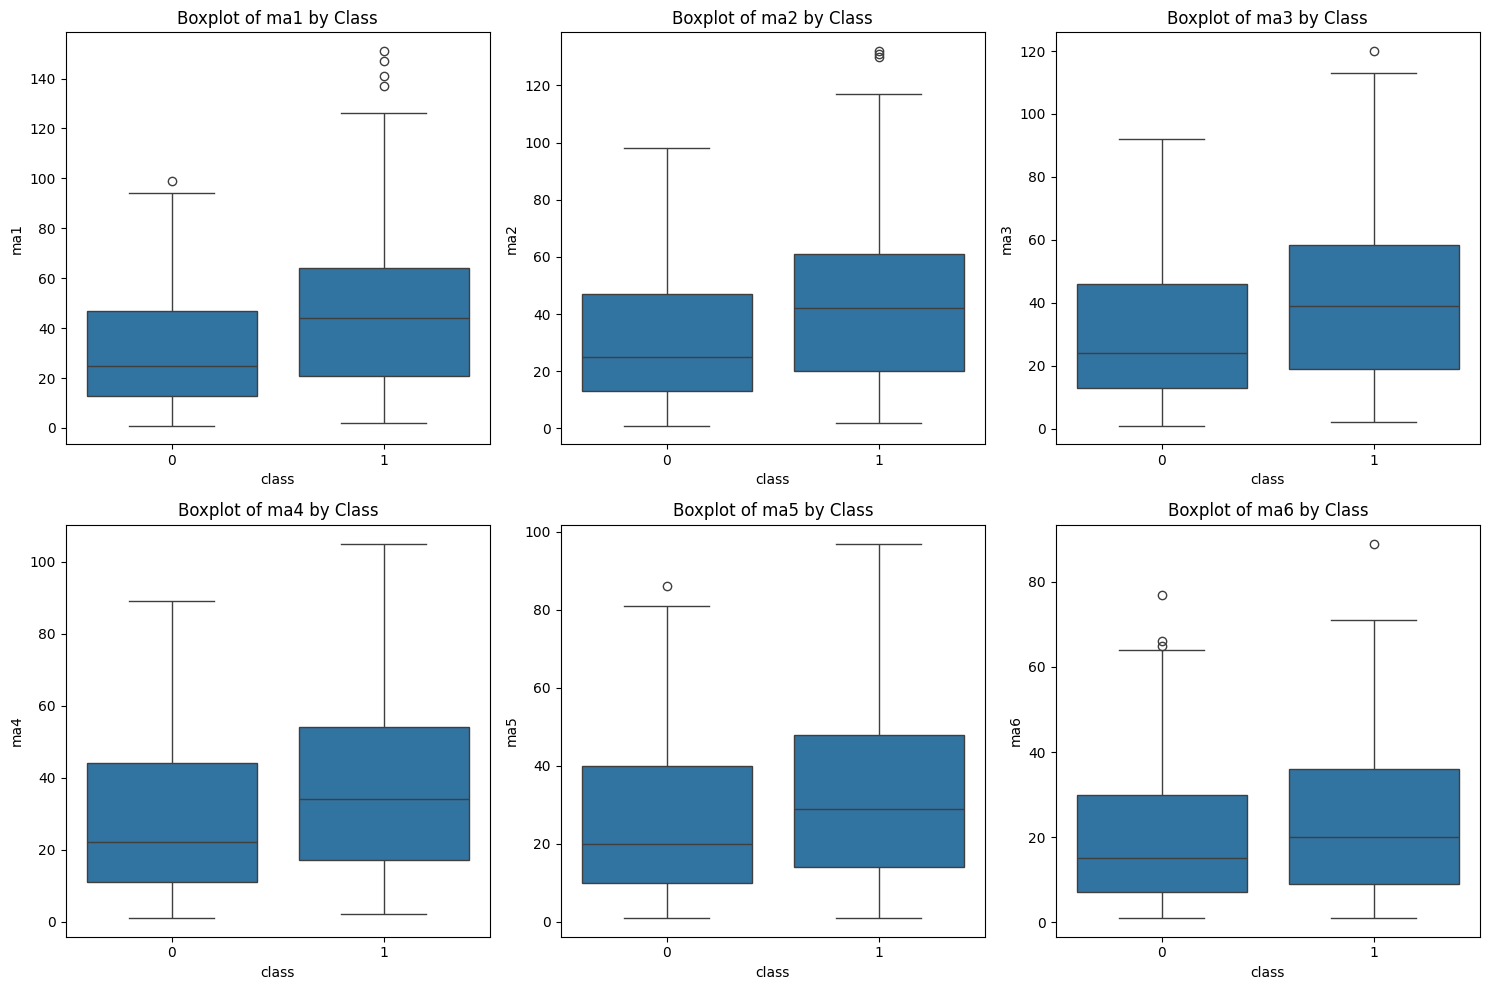

In [30]:
### box plot -- good to show quartiles

# continuous features
plt.figure(figsize=(20, 15))
for i, col in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='class', y=col, data=df)
    plt.title(f'Boxplot of {col} by Class')
plt.tight_layout()
plt.show()



# integer features
plt.figure(figsize=(15, 10))
for i, col in enumerate(integer_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='class', y=col, data=df)
    plt.title(f'Boxplot of {col} by Class')
plt.tight_layout()
plt.show()

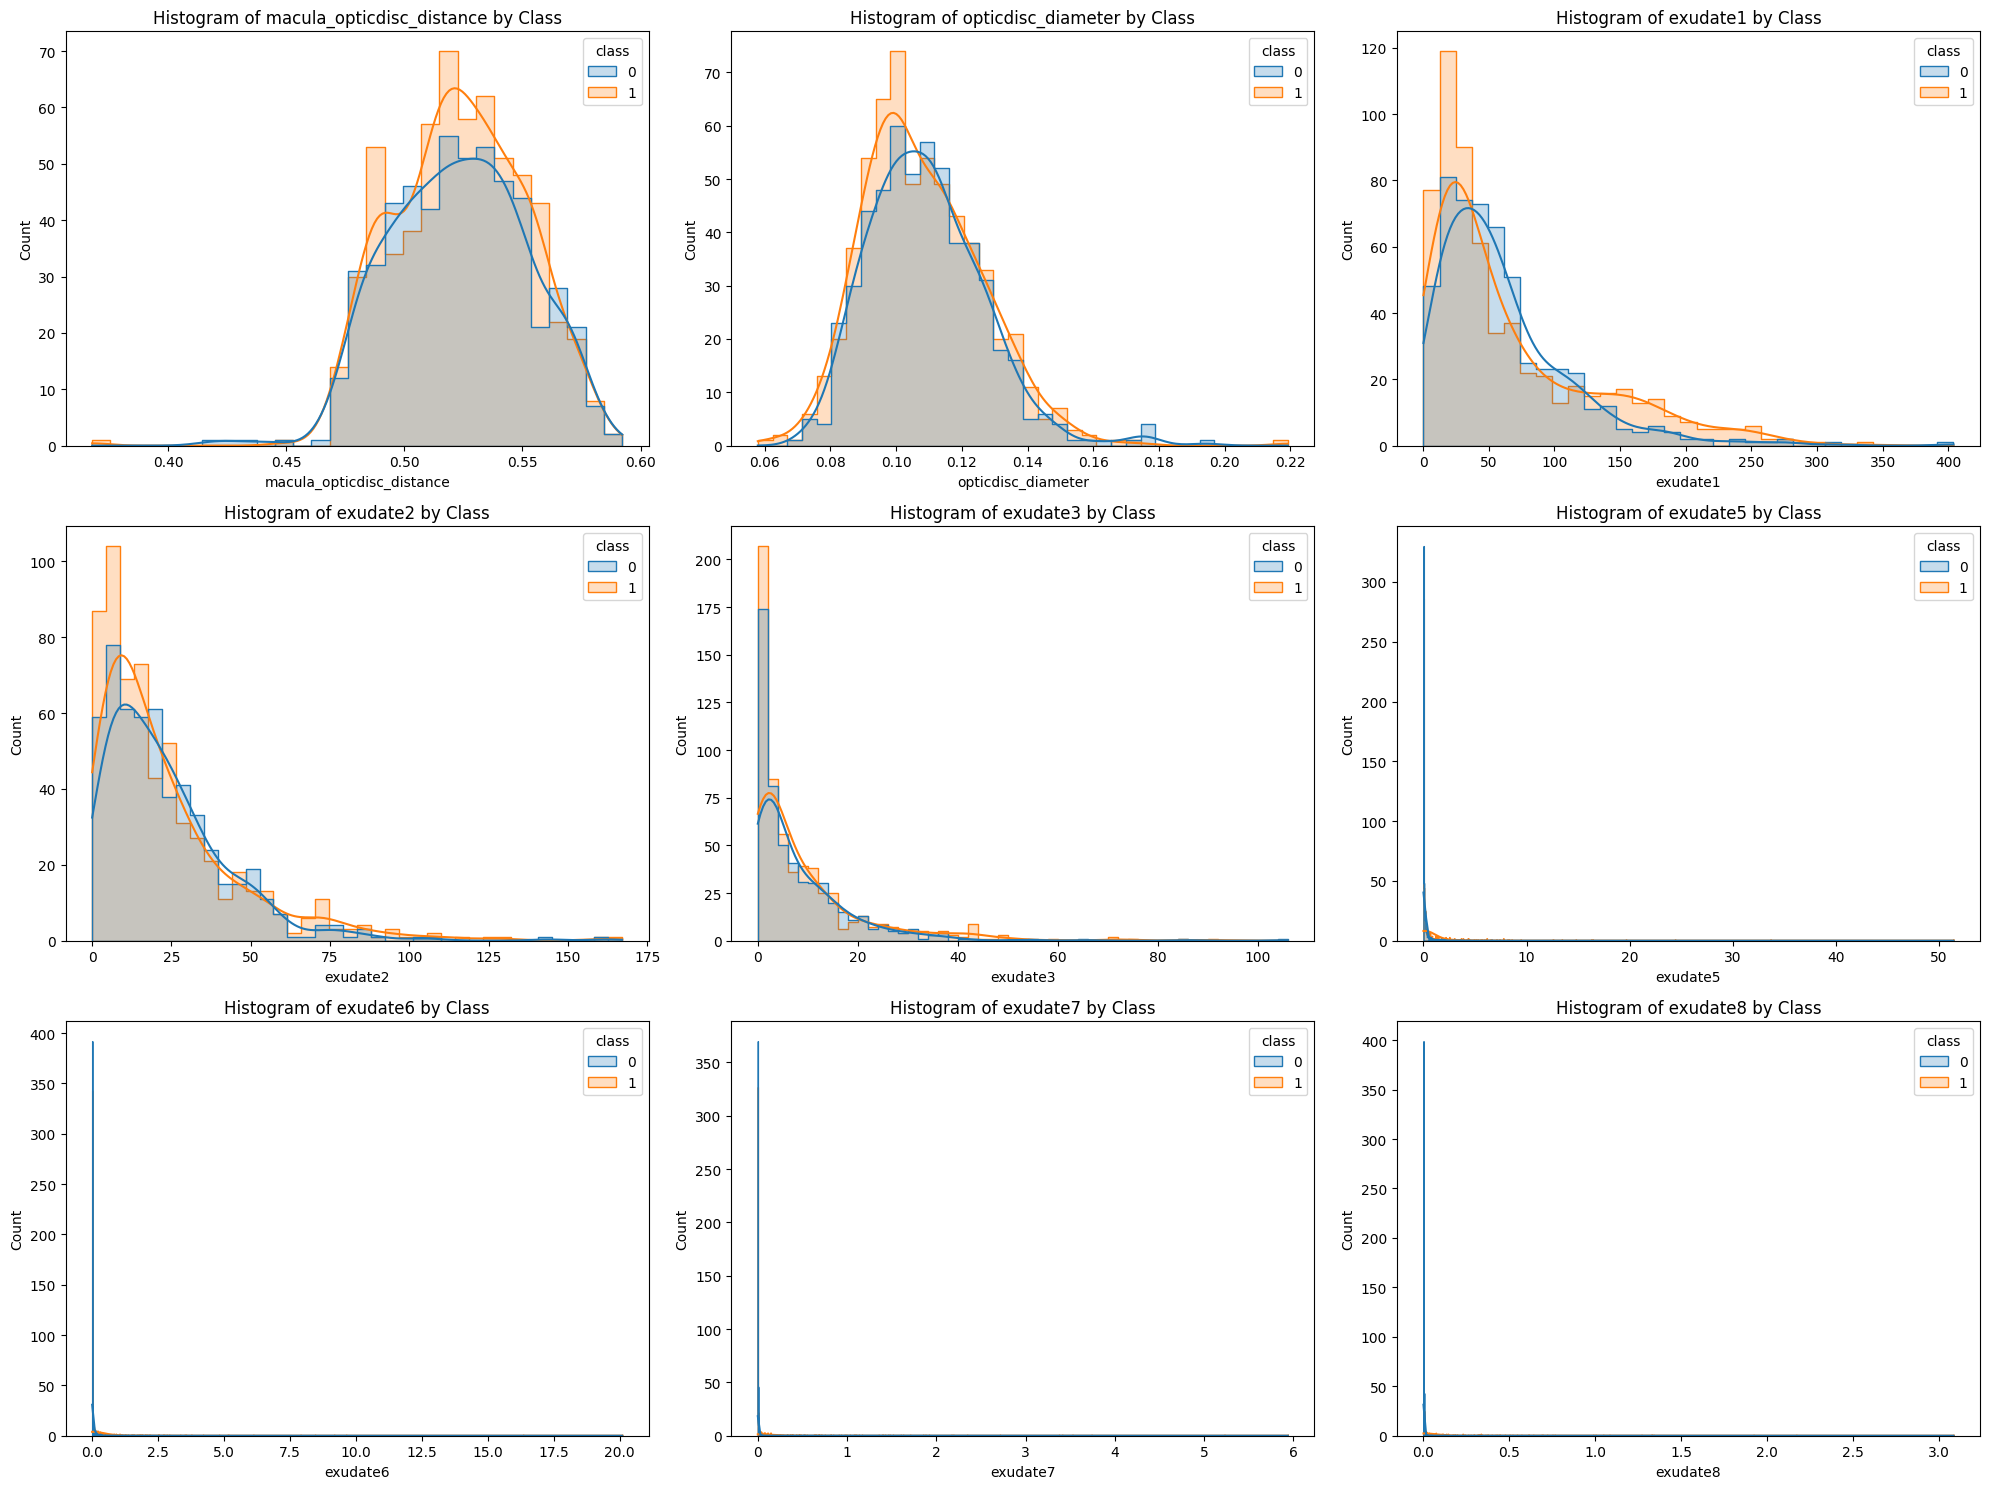

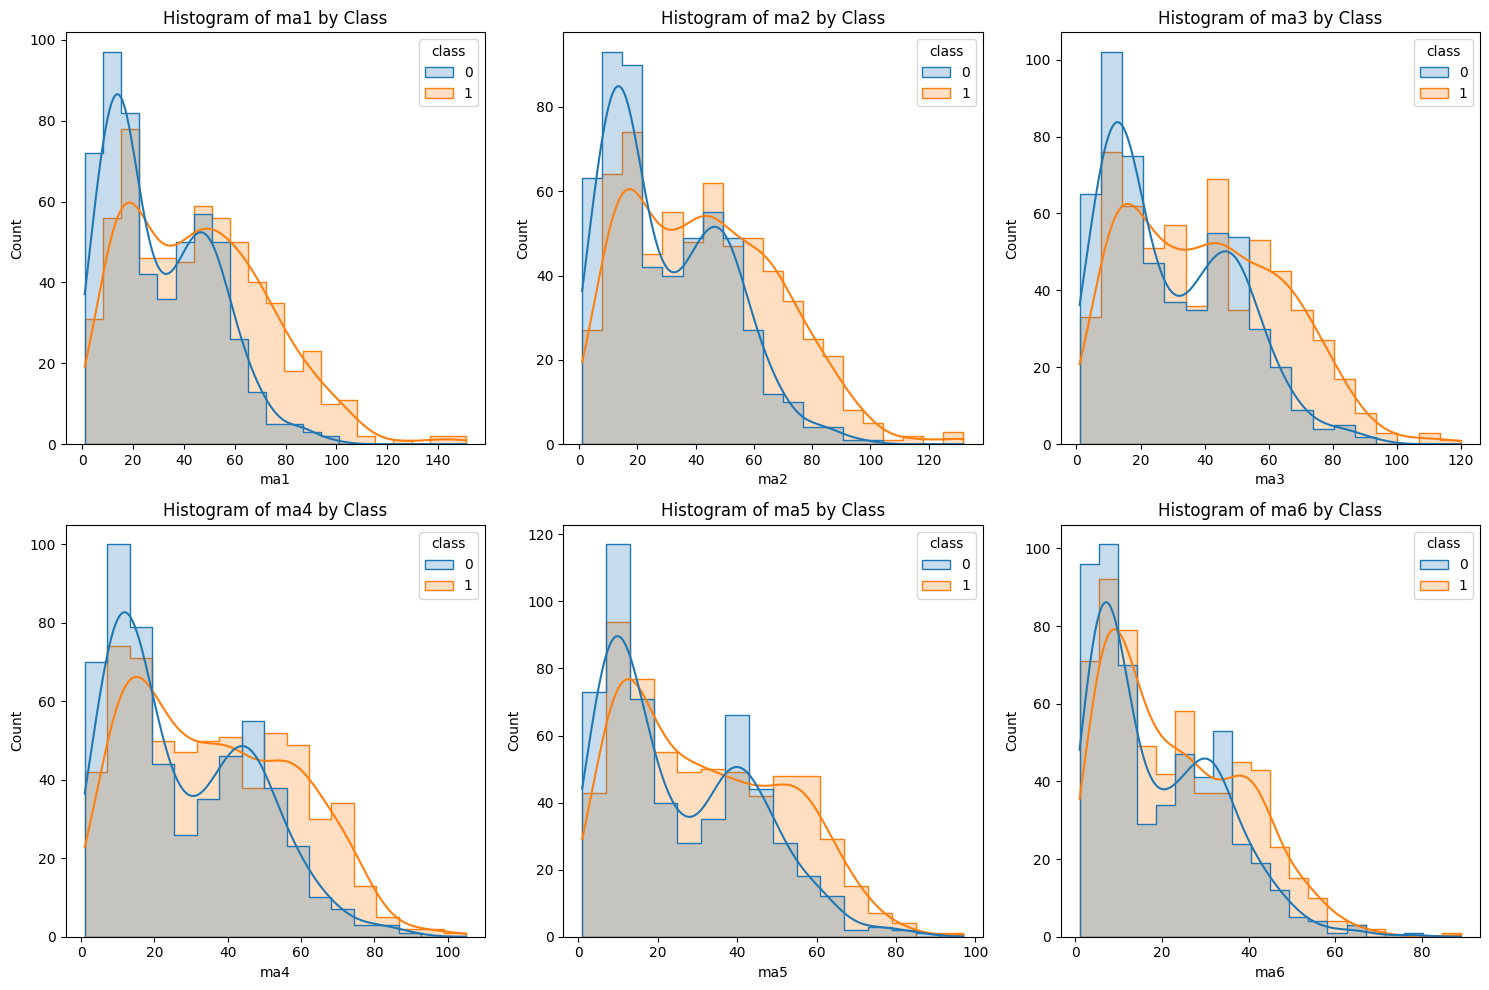

In [31]:
### Histogtam




# continuous features
plt.figure(figsize=(20, 15))
for i, col in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, hue='class', kde=True, element='step')
    plt.title(f'Histogram of {col} by Class')
plt.tight_layout()
plt.show()





# integer features
plt.figure(figsize=(15, 10))
for i, col in enumerate(integer_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, hue='class', kde=True, element='step')
    plt.title(f'Histogram of {col} by Class')
plt.tight_layout()
plt.show()

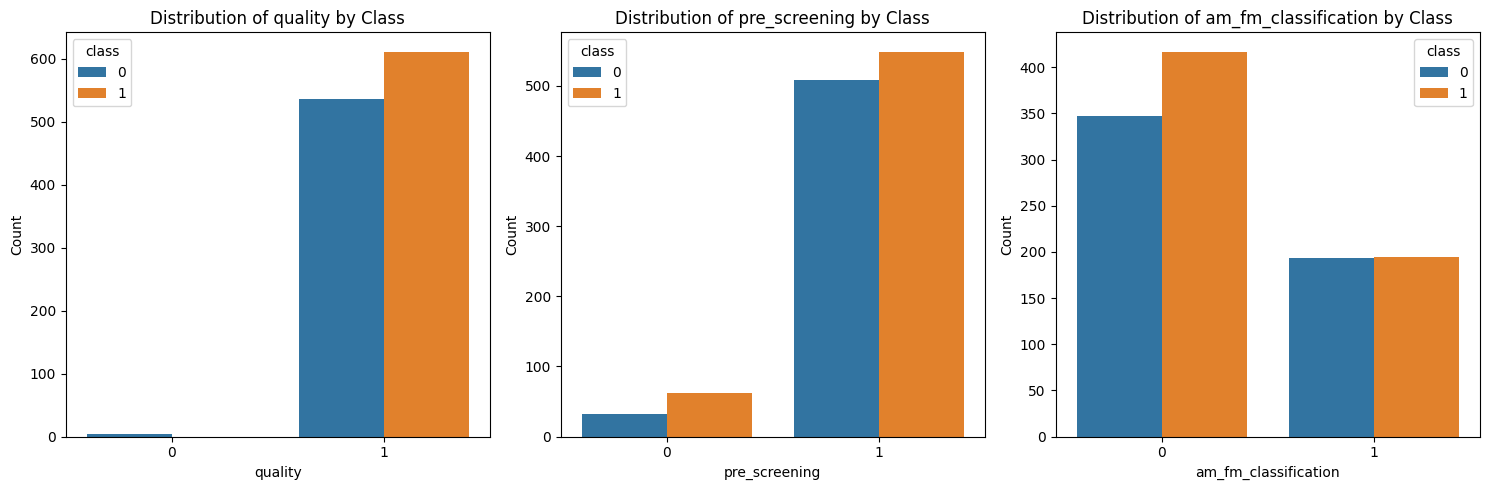

In [32]:
### Count plot with binary variables


# list of binary features
binary_features = ['quality', 'pre_screening', 'am_fm_classification']

plt.figure(figsize=(15, 5))
for i, col in enumerate(binary_features, 1):
    plt.subplot(1, len(binary_features), i)
    sns.countplot(x=col, hue='class', data=df)
    plt.title(f'Distribution of {col} by Class')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Correlation Analysis

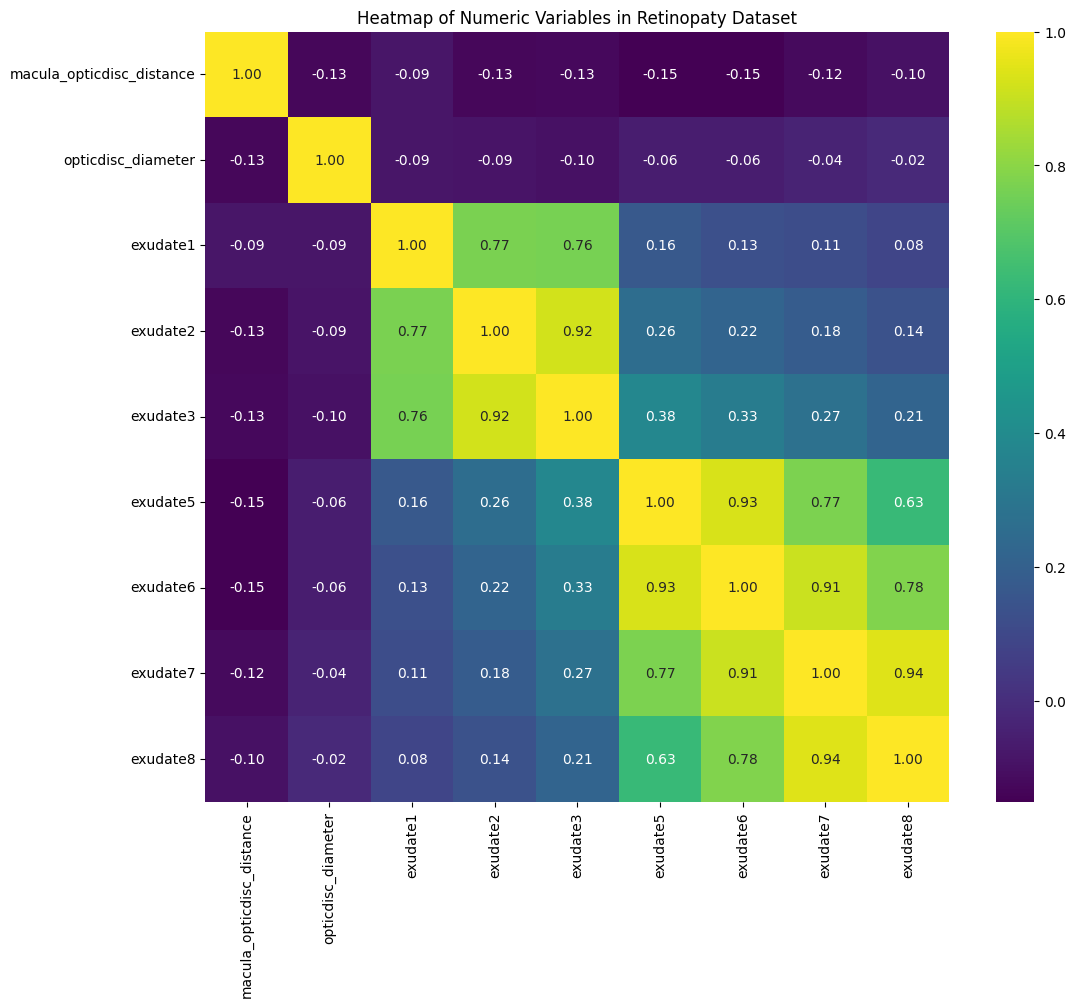

In [33]:
### Pearson Correlation between Numeric Variables


# Compute correlation matrix for numeric columns
corr_matrix = df[continuous_features].corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Numeric Variables in Retinopaty Dataset')
plt.show()

A numeric feature: point-biserial correlation coefficient--{'macula_opticdisc_distance': 0.008466310929525576, 'opticdisc_diameter': -0.030867673585674466, 'exudate1': 0.05801482465796773, 'exudate2': 0.0004790854664405283, 'exudate3': 0.03828142369273258, 'exudate5': 0.14227286327119845, 'exudate6': 0.151424387643398, 'exudate7': 0.18477209454152496, 'exudate8': 0.1773128302723655, 'ma1': 0.2926029110203911, 'ma2': 0.2663378516525347, 'ma3': 0.2346910985342625, 'ma4': 0.19751089836623534, 'ma5': 0.16163067417355922, 'ma6': 0.12786078781579457}

A numeric feature: point-biserial correlation p-value --{'macula_opticdisc_distance': 0.7741701891860454, 'opticdisc_diameter': 0.2954039832899319, 'exudate1': 0.04909652196813509, 'exudate2': 0.9870461303424467, 'exudate3': 0.19435088131405534, 'exudate5': 1.25828250057388e-06, 'exudate6': 2.4499076562853455e-07, 'exudate7': 2.678986071784879e-10, 'exudate8': 1.385937454936126e-09, 'ma1': 3.713052227051868e-24, 'ma2': 3.834417660976483e-20, 'm

<ipython-input-34-fe1be3c9b8b3>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y='Variable', data=corr_df, palette='coolwarm')


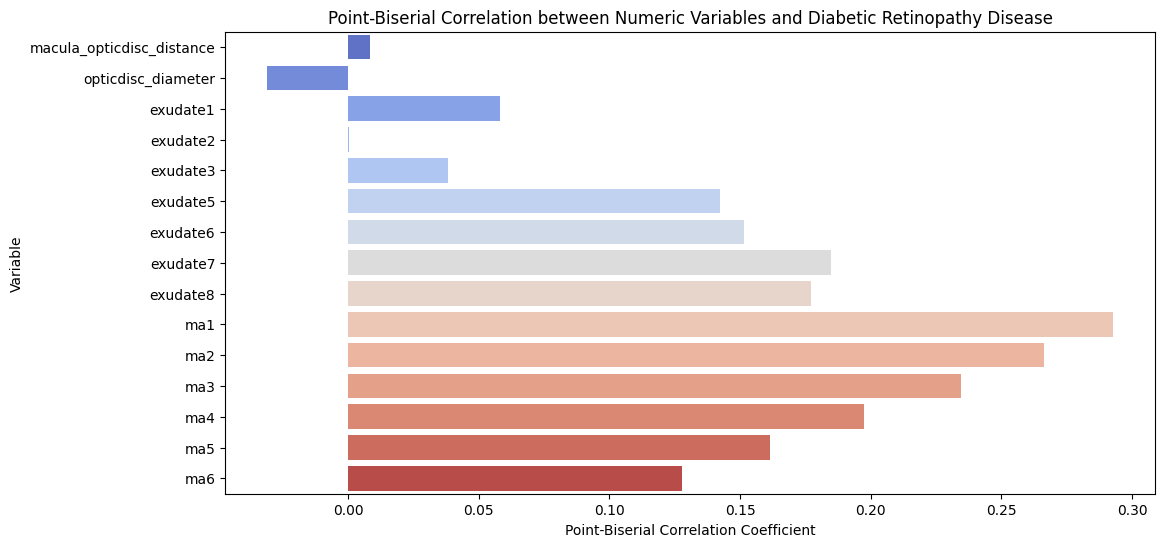

In [34]:
### point-biserial correlation between class and continous variables


# Calculate point-biserial correlation

point_biserial_corrs = {}
p_values = {}
for col in con_int:
    corr, p_value = stats.pointbiserialr(df[col], df['class'])
    point_biserial_corrs[col] = corr
    p_values[col] = p_value
print(f"A numeric feature: point-biserial correlation coefficient--{point_biserial_corrs}\n")
print(f"A numeric feature: point-biserial correlation p-value --{p_values}")


# Convert the results to a DataFrame for easy plotting
corr_df = pd.DataFrame(list(point_biserial_corrs.items()), columns=['Variable', 'Correlation'])


# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Correlation', y='Variable', data=corr_df, palette='coolwarm')
plt.title('Point-Biserial Correlation between Numeric Variables and Diabetic Retinopathy Disease')
plt.xlabel('Point-Biserial Correlation Coefficient')
plt.ylabel('Variable')
plt.show()

## Data Transformation

In [35]:
### now we will prepare data for predictive modeling

# standardization of continous variables

scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])
df[integer_features] = scaler.fit_transform(df[integer_features])

# log transform tnteger features
#df[integer_features] = df[integer_features].apply(lambda x: np.log1p(x))



# combine all transformed features
X = df[continuous_features + integer_features+binary_features]

 # get target variable
y = df['class']

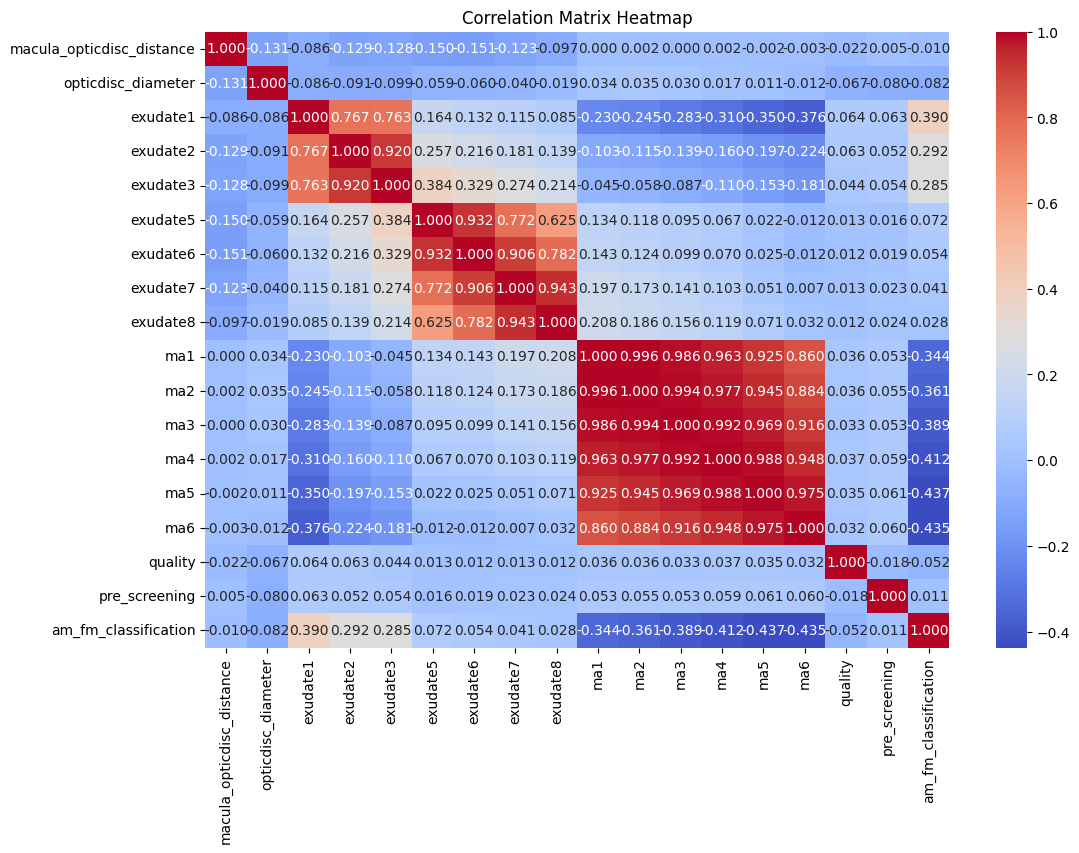

In [36]:
### just to check multicoliniarity before modeling

# calculate correlation matrix
corr_matrix = X.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()



### huge multicoliniarity!!! - we will need to come up with solutions!!!

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# stratify=y is good practice

## <center> Predictive Modeling

Training Random Forest
Random Forest Accuracy: 0.6618
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       162
           1       0.71      0.62      0.66       184

    accuracy                           0.66       346
   macro avg       0.66      0.66      0.66       346
weighted avg       0.67      0.66      0.66       346



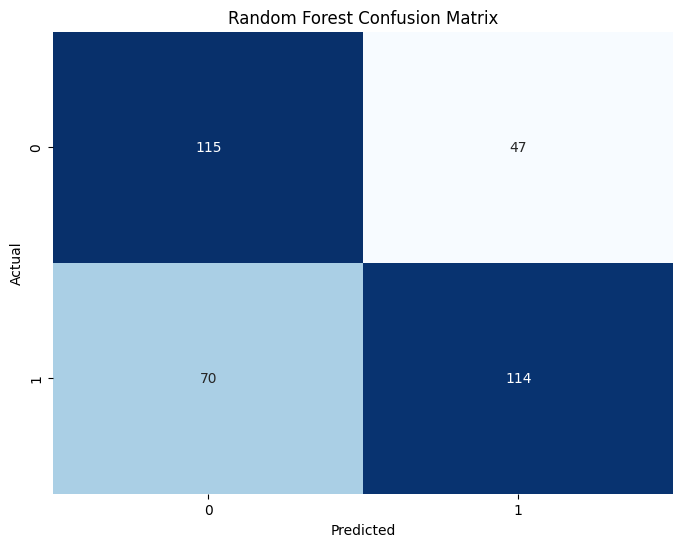

Training Logistic Regression
Logistic Regression Accuracy: 0.7081
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       162
           1       0.81      0.59      0.68       184

    accuracy                           0.71       346
   macro avg       0.73      0.72      0.71       346
weighted avg       0.73      0.71      0.70       346



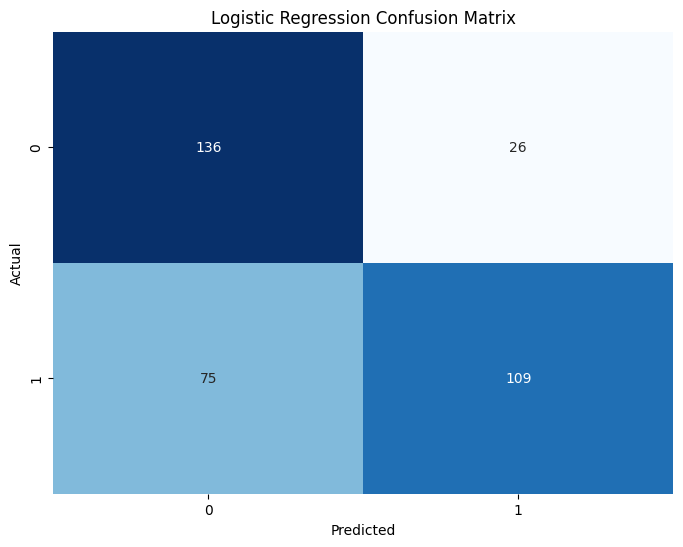

Training SVM
SVM Accuracy: 0.7052
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       162
           1       0.83      0.57      0.67       184

    accuracy                           0.71       346
   macro avg       0.73      0.71      0.70       346
weighted avg       0.74      0.71      0.70       346



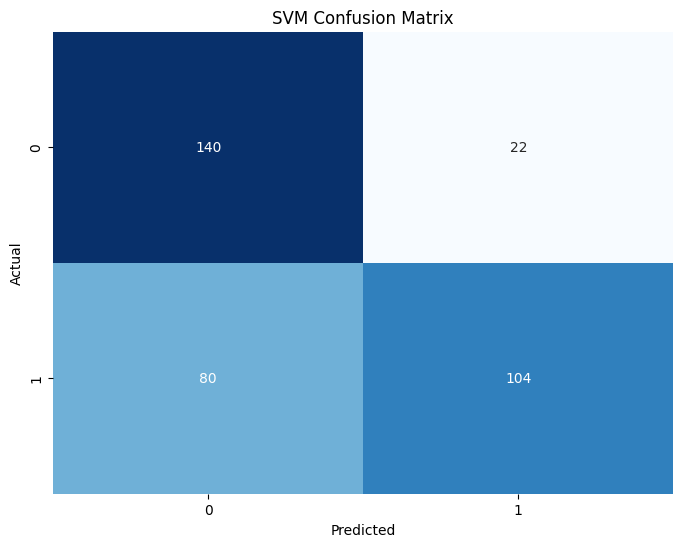

Training KNN
KNN Accuracy: 0.6156
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       162
           1       0.66      0.57      0.61       184

    accuracy                           0.62       346
   macro avg       0.62      0.62      0.62       346
weighted avg       0.62      0.62      0.62       346



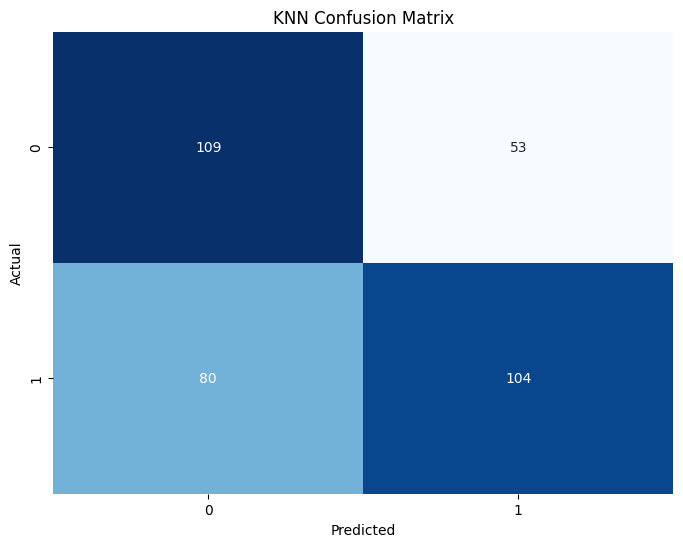

Training Gradient Boosting
Gradient Boosting Accuracy: 0.6850
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       162
           1       0.73      0.65      0.69       184

    accuracy                           0.68       346
   macro avg       0.69      0.69      0.68       346
weighted avg       0.69      0.68      0.69       346



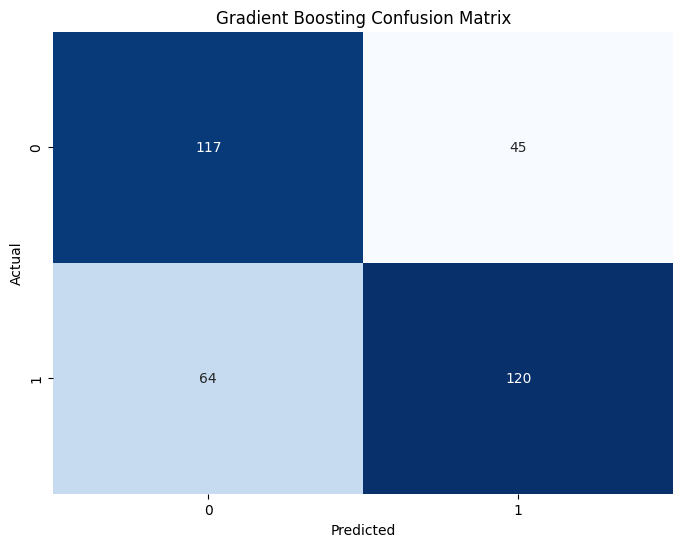

Training XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:00:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6994
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       162
           1       0.74      0.68      0.71       184

    accuracy                           0.70       346
   macro avg       0.70      0.70      0.70       346
weighted avg       0.70      0.70      0.70       346



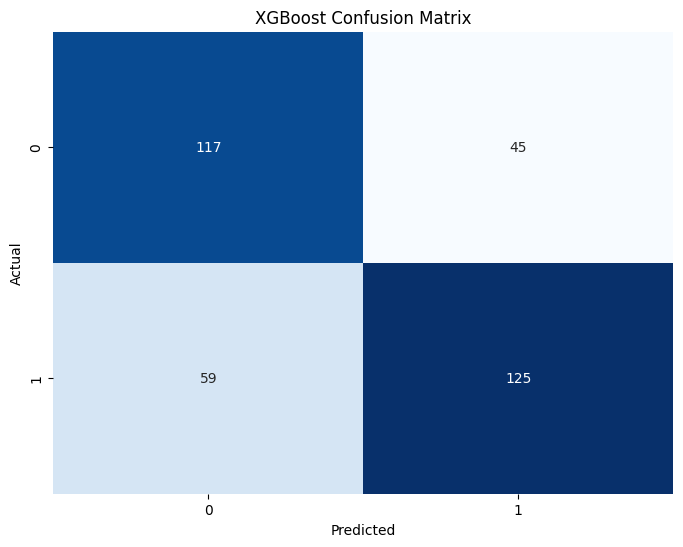

Training Neural Network (MLP)
Neural Network (MLP) Accuracy: 0.6994
Neural Network (MLP) Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       162
           1       0.83      0.55      0.66       184

    accuracy                           0.70       346
   macro avg       0.73      0.71      0.70       346
weighted avg       0.73      0.70      0.69       346



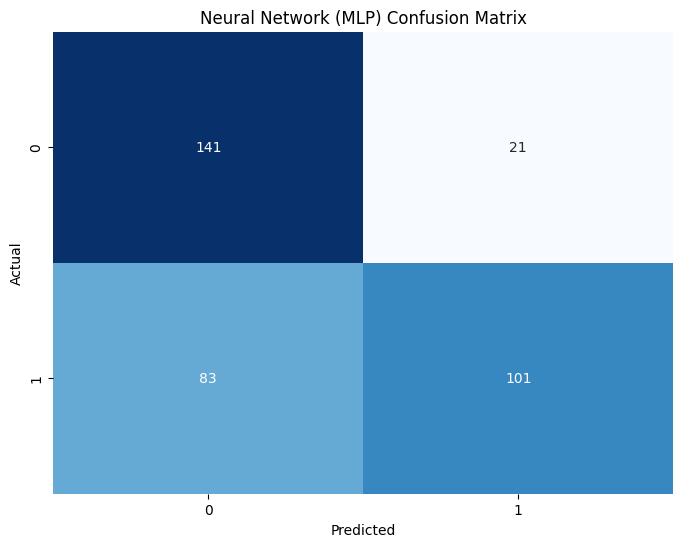

Training AdaBoost
AdaBoost Accuracy: 0.6647
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67       162
           1       0.72      0.61      0.66       184

    accuracy                           0.66       346
   macro avg       0.67      0.67      0.66       346
weighted avg       0.67      0.66      0.66       346



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


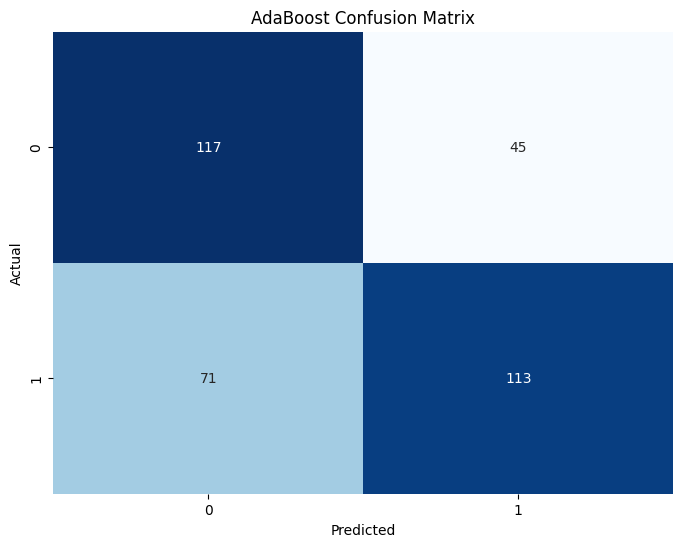

Training Naive Bayes
Naive Bayes Accuracy: 0.6445
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68       162
           1       0.74      0.51      0.60       184

    accuracy                           0.64       346
   macro avg       0.66      0.65      0.64       346
weighted avg       0.67      0.64      0.64       346



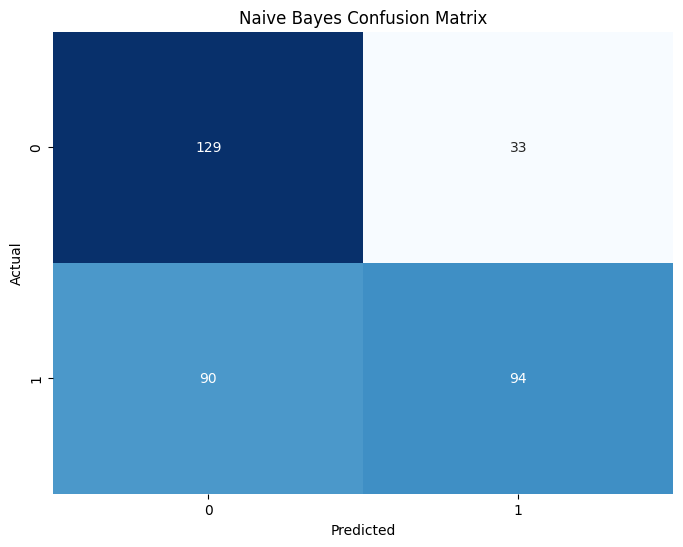

Training Decision Tree
Decision Tree Accuracy: 0.5925
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       162
           1       0.61      0.64      0.63       184

    accuracy                           0.59       346
   macro avg       0.59      0.59      0.59       346
weighted avg       0.59      0.59      0.59       346



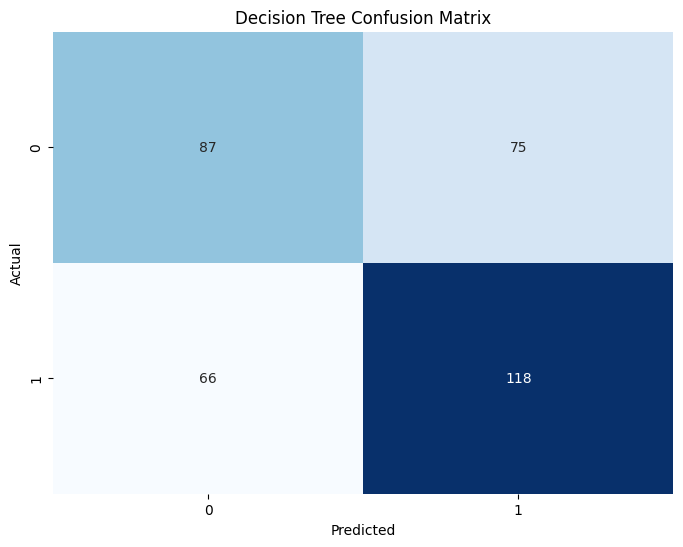

Training LightGBM
[LightGBM] [Info] Number of positive: 427, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2475
[LightGBM] [Info] Number of data points in the train set: 805, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530435 -> initscore=0.121890
[LightGBM] [Info] Start training from score 0.121890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

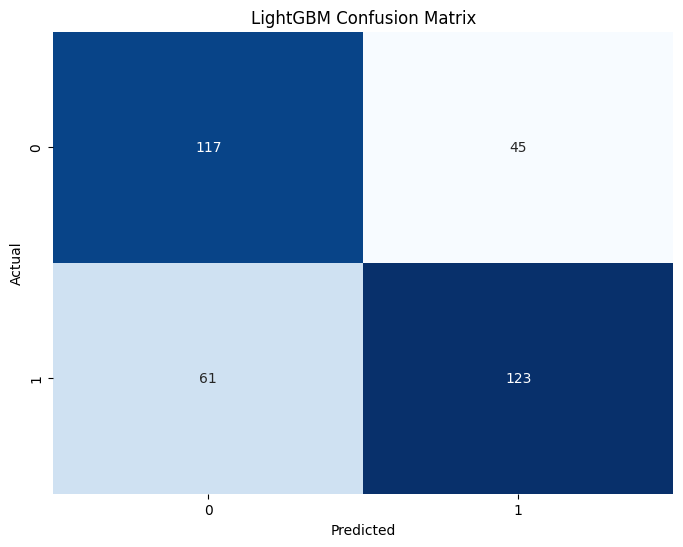

In [38]:
### Let's first loop over classification algorithms


models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# Dictionary to store model results
results = {}

# Train, predict, and evaluate each model
for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Store the results
    results[name] = {
        "Accuracy": accuracy,
        "Classification Report": report
    }

    # Print accuracy and classification report
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:\n{report}")

    # Generate and visualize the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Regularization

Lasso Logistic Regression (L1) Accuracy: 0.7369942196531792
Lasso Logistic Regression (L1) Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.85      0.75       162
           1       0.83      0.64      0.72       184

    accuracy                           0.74       346
   macro avg       0.75      0.74      0.74       346
weighted avg       0.76      0.74      0.74       346



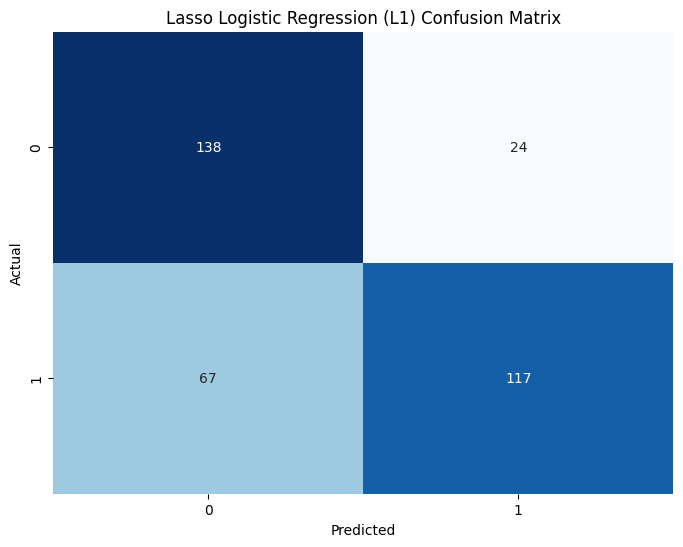

In [39]:
### L1 Regularization (Lasso)


model_lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model_lasso.fit(X_train, y_train)

# Predictions
y_pred_lasso = model_lasso.predict(X_test)

# Evaluate the model
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
report_lasso = classification_report(y_test, y_pred_lasso)

print("Lasso Logistic Regression (L1) Accuracy:", accuracy_lasso)
print("Lasso Logistic Regression (L1) Classification Report:\n", report_lasso)

# Confusion Matrix
cm_lasso = confusion_matrix(y_test, y_pred_lasso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lasso, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Lasso Logistic Regression (L1) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Ridge Logistic Regression (L2) Accuracy: 0.708092485549133
Ridge Logistic Regression (L2) Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.84      0.73       162
           1       0.81      0.59      0.68       184

    accuracy                           0.71       346
   macro avg       0.73      0.72      0.71       346
weighted avg       0.73      0.71      0.70       346



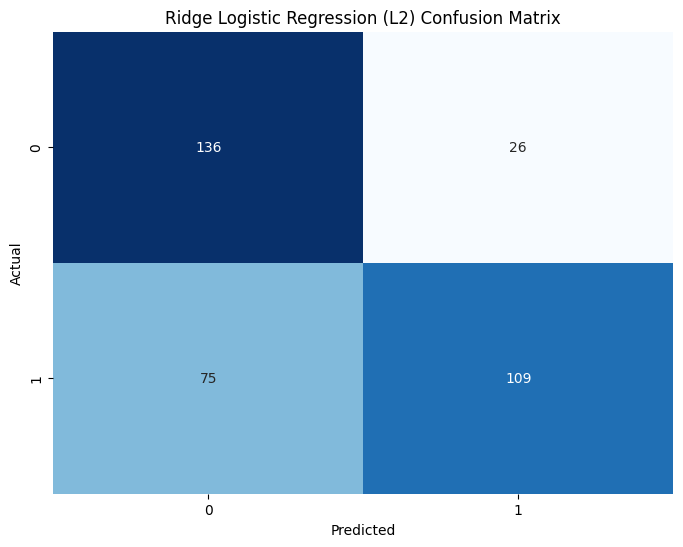

In [40]:
### L2 Regularization (Ridge)


model_ridge = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
model_ridge.fit(X_train, y_train)

# Predictions
y_pred_ridge = model_ridge.predict(X_test)

# Evaluate the model
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
report_ridge = classification_report(y_test, y_pred_ridge)

print("Ridge Logistic Regression (L2) Accuracy:", accuracy_ridge)
print("Ridge Logistic Regression (L2) Classification Report:\n", report_ridge)

# Confusion Matrix
cm_ridge = confusion_matrix(y_test, y_pred_ridge)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Ridge Logistic Regression (L2) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Elastic Net Logistic Regression Accuracy: 0.6820809248554913
Elastic Net Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.77      0.69       162
           1       0.75      0.60      0.67       184

    accuracy                           0.68       346
   macro avg       0.69      0.69      0.68       346
weighted avg       0.69      0.68      0.68       346



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


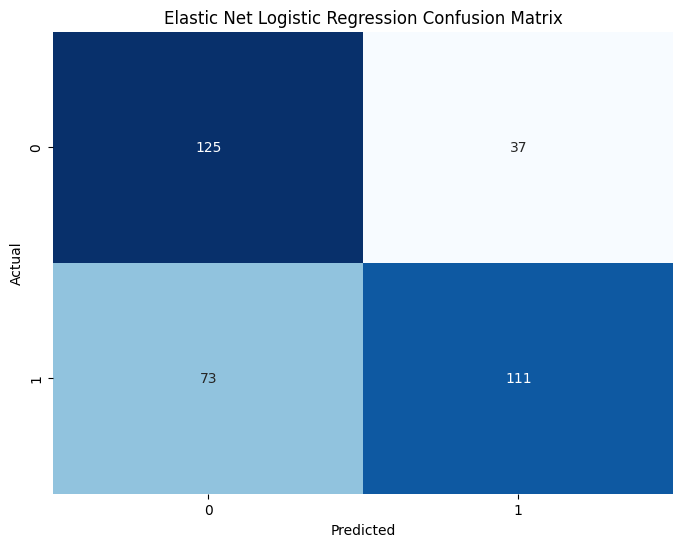

In [41]:
### Elastic Net Regularization


model_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=42)
model_elastic.fit(X_train, y_train)

# Predictions
y_pred_elastic = model_elastic.predict(X_test)

# Evaluate the model
accuracy_elastic = accuracy_score(y_test, y_pred_elastic)
report_elastic = classification_report(y_test, y_pred_elastic)

print("Elastic Net Logistic Regression Accuracy:", accuracy_elastic)
print("Elastic Net Logistic Regression Classification Report:\n", report_elastic)

# Confusion Matrix
cm_elastic = confusion_matrix(y_test, y_pred_elastic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_elastic, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Elastic Net Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2'}
Best Model Accuracy: 0.7398843930635838
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.85      0.75       162
           1       0.83      0.65      0.73       184

    accuracy                           0.74       346
   macro avg       0.75      0.75      0.74       346
weighted avg       0.76      0.74      0.74       346



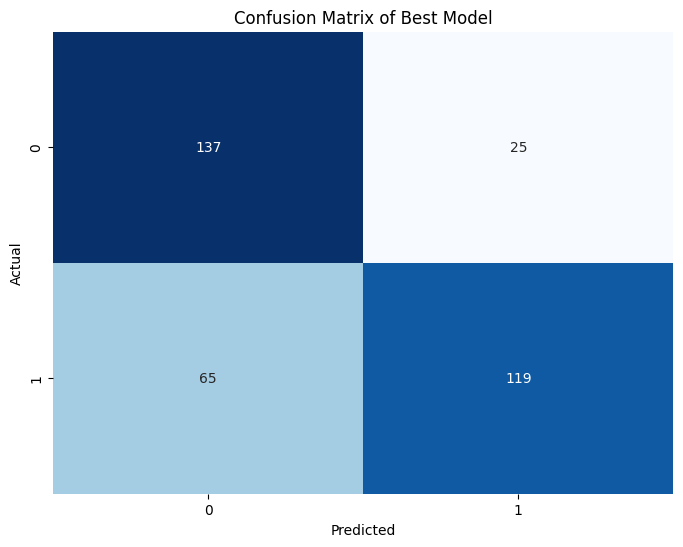

In [42]:
### regularization with cross-validation


# Define model
model = LogisticRegression(solver='liblinear', random_state=42)

# Define parameter grid: here, C controls regularization strength
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization techniques
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'l1_ratio': [0.1, 0.5, 0.9]  # Only used for elasticnet
}

# initialize GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit model
grid_search.fit(X_train, y_train)

# Get best model parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Predict with best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate best model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Model Accuracy:", accuracy)
print("Best Model Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix of Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Dimentionality Reduction

In [43]:
# Define pipeline with StandardScaler, PCA, and Logistic Regression
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('logistic', LogisticRegression(random_state=42))
])

# Fit pipeline on training data
pca_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pca_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("PCA + Logistic Regression Accuracy:", accuracy)
print("PCA + Logistic Regression Classification Report:\n", report)

PCA + Logistic Regression Accuracy: 0.6589595375722543
PCA + Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.73      0.67       162
           1       0.72      0.59      0.65       184

    accuracy                           0.66       346
   macro avg       0.67      0.66      0.66       346
weighted avg       0.67      0.66      0.66       346



## Model Optimization

In [46]:
# Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

# Initialize the model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, scoring='accuracy', cv=5, verbose=1)
gb_grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters for Gradient Boosting: {gb_grid_search.best_params_}")

# Predict and evaluate using the best model
y_pred = gb_grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Gradient Boosting Accuracy after tuning: {accuracy:.4f}")
print(f"Classification Report:\n{report}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Gradient Boosting Accuracy after tuning: 0.7052
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       162
           1       0.74      0.68      0.71       184

    accuracy                           0.71       346
   macro avg       0.71      0.71      0.71       346
weighted avg       0.71      0.71      0.71       346



In [47]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5]
}

# Initialize the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='accuracy', cv=5, verbose=1)
xgb_grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")

# Predict and evaluate using the best model
y_pred = xgb_grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"XGBoost Accuracy after tuning: {accuracy:.4f}")
print(f"Classification Report:\n{report}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:12:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:12:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost Accuracy after tuning: 0.6965
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69       162
           1       0.73      0.68      0.70       184

    accuracy                           0.70       346
   macro avg       0.70      0.70      0.70       346
weighted avg       0.70      0.70      0.70       346



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:13:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [48]:
# Define parameter grid for AdaBoost
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Initialize model
ada_model = AdaBoostClassifier(random_state=42)

# Perform GridSearchCV
ada_grid_search = GridSearchCV(estimator=ada_model, param_grid=ada_param_grid, scoring='accuracy', cv=5, verbose=1)
ada_grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters for AdaBoost: {ada_grid_search.best_params_}")

# Predict and evaluate using best model
y_pred = ada_grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"AdaBoost Accuracy after tuning: {accuracy:.4f}")
print(f"Classification Report:\n{report}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 50}
AdaBoost Accuracy after tuning: 0.6647
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67       162
           1       0.72      0.61      0.66       184

    accuracy                           0.66       346
   macro avg       0.67      0.67      0.66       346
weighted avg       0.67      0.66      0.66       346



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
